## CMS - task III - e

* **Dataset


In [59]:
import os
import torch
import numpy as np
import copy

from itertools import combinations

import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision.transforms.functional import rotate

# convert data to torch.FloatTensor
transform = Compose([ToTensor()])
                        # Lambda(lambda img: (img, rotate(img, 30)) )])

# load the training and test datasets
train_data = datasets.MNIST(root='datasets/task_iii_e', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='datasets/task_iii_e', train=False,
                                  download=True, transform=transform)

In [2]:
indices = (train_data.targets == 1) | (train_data.targets == 2) # only two digits
train_data.data, train_data.targets = train_data.data[indices], train_data.targets[indices]

In [3]:
indices = (test_data.targets == 1) | (test_data.targets == 2) # only two digits
test_data.data, test_data.targets = test_data.data[indices], test_data.targets[indices]

### Dataset preparation

In [4]:
train_rotated_path = "datasets/task_iii_e/MNIST/rotated/train/"
test_rotated_path = "datasets/task_iii_e/MNIST/rotated/test/"

In [120]:
from tqdm import tqdm

"""
    The tensor will be stored and named by the following convention:
    {tensor_idx}_{label}_{degree_of_rotation}.pt
"""


def save_transformed_tensors(data, path):
    for idx, sample in tqdm(enumerate(data)):
        image = sample[0]
        label = sample[1]
        torch.save(image, path + str(idx) + "_" + str(label) + "_0.pt")
    
        for deg in [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]:
            torch.save(rotate(image, deg), path + str(idx) + "_" + str(label) + "_{}.pt".format(str(deg)))

In [121]:
save_transformed_tensors(train_data, train_rotated_path)

12700it [00:45, 279.33it/s]


In [122]:
save_transformed_tensors(test_data, test_rotated_path)

2167it [00:08, 265.24it/s]


In [112]:
import os

len(os.listdir(save_rotated_path))/12 # for each tensor we have 12 rotations (including the identity).

12700.0

### Now we'll create a map that receives a tensor idx and returns its path. Will be useful for our dataset class

In [5]:
"tensor_idx_map: idx -> file_path"

train_tensor_idx_map = {idx: train_rotated_path + file for idx, file in enumerate(os.listdir(train_rotated_path))}

In [6]:
test_tensor_idx_map = {idx: test_rotated_path + file for idx, file in enumerate(os.listdir(test_rotated_path))}

In [7]:
train_tensor_idx_map[0]

'datasets/task_iii_e/MNIST/rotated/train/10039_1_330.pt'

### Lastly, our dataset class

In [8]:
from torchvision.transforms.functional import rotate
from torch.utils.data import Dataset

class DiscreteRotationDataset(Dataset):
    """
        This class will hold our rotationed digits dataset.
        in each __getitem(self, idx)__, we are going to return a digit and its transformed version.
    """

    def __init__(self, data, tensor_map, degree = None, return_pairs = False):
        """
        Arguments:
            data: the training or test data already in MNIST torch format.
            degrees: the degrees of rotation.
        """
        self.data = data
        self.tensor_map = tensor_map
        self.return_pairs = return_pairs # this will be True later, when training the LieGAN
        self.degree = degree # if some specific value theta is passed, then only pairs of (tensor, rotated(tensor, theta)) are returned
        self.angles = list(range(0, 360, 30))
        self.angles = [str(k) for k in self.angles]

    def __len__(self):
        return len(self.tensor_map)

    def __getitem__(self, idx):
        """
            each sample returned will consist of the original image
            and the rotated image.
        """

        file_name = self.tensor_map[idx]
        y = torch.tensor(int(file_name.split("/")[-1].split("_")[1]), dtype=torch.long)
        X = torch.load(file_name)
        
        if self.return_pairs:
            X_angle = file_name.split("_")[-1].split(".")[0]

            if self.degree is None:
                # here, we choose only transformed versions that are different from X.
                gX_angle = np.random.choice(np.setdiff1d(self.angles, X_angle))
            else:
                gX_angle = str(self.degree)
            gX = torch.load("_".join(file_name.split("_")[:-1]) + "_" + gX_angle + ".pt")
            
            return (X, gX, float(gX_angle), y)
            
        return X, y

In [9]:
train_dataset = DiscreteRotationDataset(train_data, train_tensor_idx_map, return_pairs = True)

In [10]:
test_dataset = DiscreteRotationDataset(test_data, test_tensor_idx_map, return_pairs = True)

In [11]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

(-0.5, 27.5, 27.5, -0.5)

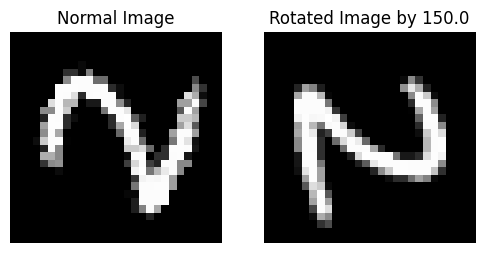

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
batch = next(iter(train_loader))
images, images_rot, angles, _ = batch

# get one image from the batch
img_sample = np.squeeze(images[1])
img_sample_rotated = np.squeeze(images_rot[1])

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 5))  # 1 row, 2 columns

# Display the first image in the first subplot
axes[0].imshow(img_sample, cmap='gray')
axes[0].set_title('Normal Image')
axes[0].axis('off')  # Hide the axis

# Display the rotated image in the second subplot
axes[1].imshow(img_sample_rotated, cmap='gray')
axes[1].set_title('Rotated Image by {}'.format(angles[3]))
axes[1].axis('off')  # Hide the axis

## Convolutional AE

I will follow the same architecture used in [5]. Doing with convolution + pooling layers should suppress the effects of translations on the hidden representations. I tried first a vanilla AE with linear layers and activations only, but the results were not good. I think the Conv AE, as the paper uses, is better suited since we are talking about images.

In [72]:
class ConvAutoencoder(nn.Module):
    
    def __init__(self, mode=None, n_latent=3):
        super(ConvAutoencoder, self).__init__()
        
        self.mode = mode
        # Encoder 
        self.enc = nn.Sequential(
            nn.Conv2d(1, 128, 3, stride=2, padding=1, bias=True), 
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, stride=2, padding=1, bias=True), 
            nn.ReLU(),
            nn.Conv2d(64, 16, 3, stride=2, padding=1, bias=True), 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 64, bias=True), 
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            # nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, n_latent))
        
        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(n_latent, 32, bias=True), 
            nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            # nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, 256, bias=True),
            nn.ReLU(), 
            nn.Unflatten(1, (16,4,4)),
            nn.ConvTranspose2d(16, 64, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
        
    def forward_once(self, x):
        latent = self.enc(x)
        out = self.dec(latent)
        return out, latent
    
    def forward(self, x): 
        
        if self.mode == 'siamese':
            # x[0] is the normal digit
            # x[1] is the rotated one
            # if mode is siamese, the forward arg 'x' should be passed as a tuple
            out_x, x_latent = self.forward_once(x[0])
            out_x_rot, x_rot_latent = self.forward_once(x[1])
            
            return out_x, x_latent, out_x_rot, x_rot_latent
        
        return self.dec(self.enc(x))

### For the Orthogonal group, we expect n(n-1)/2 generators.

Since I chose the latent dimension to be $n=2$, then we need just $1$ generator.

### Operator loss

\begin{equation}
\mathcal{L}_{angle-preserving} = \sum_{i}^{m} \frac{1}{m} ||DECODER(e^{\theta_{i}J}(ENCODER(x_{i}))) - x_{\theta_{i}}||^2,
\end{equation}

where $x_i, x_{\theta_{i}}, \theta_{i}$ are the original digit, the rotated digit, and the angle of rotation used, respectively. This is just an MSE for angle deviation in the latent space. The original image $x_{i}$ is encoded to get its latent representation, then the infinitesimal operator $J$ applies to it the corresponding rotation by $\theta_{i}$. If the operator

## About the exponential map

Here, we have something important to consider. The exponential map is used to get us from the Lie algebra to its corresponding group. **If the map, however, is not surjective**, then **some elements of the group will not "reachable"** by the map. As I'll show, the exponential map for $\mathbb{so}(n)$ is indeed surjective. However, there is no such guarantee in the **latent space**. The main point of Robin's paper is that, under an ideal discriminator, a generator that learns only a subspace of the true Lie algebra $\mathbb{g^{*}}$ has lower loss than a generator that learns an orthogonal Lie algebra $\mathbb{g^{*}}$. In other words, optimizing for the GAN loss leads to symmetry discovery, even if partial. Now, for surjectivity in the images domain, the exponential map is the following:

\begin{equation}
\text{exp}: \mathbb{so}(n) \rightarrow SO(n)
\end{equation}

with $n=2$. To demonstrate of surjectivity, we need to show that if A is a skew symmetric matrix, then $e^A$ is a rotation matrix. To see this, we just have to check that:

\begin{equation}
(e^A)^T = e^{A^{T}}.
\end{equation}

Then, since $A^{T} = -A$, we get:

\begin{equation}
(e^A)^T = e^{A^{T}} = e^{-A},
\end{equation}

and hence

\begin{equation}
(e^A)^T e^{A} = e^{-A} e^{A} = e^{-A + A} = e^{0} = I_n.
\end{equation}

Similarly,

\begin{equation}
(e^A)^T e^{A} = I_n.
\end{equation}

which shows that $e^{A}$ is orthogonal. Also it holds that,

\begin{equation}
det(e^{A}) = e^{tr(a)},
\end{equation}

which, since $A$ is real skew symmetric, all of its diagonal entries are $0$, so $tr(A) = 0$. As a consequence, $det(e^{A}) = +1$. For surjectivity, we have to notice that for every skew symmetric matrix $A$, there is an orthogonal matrix $P$ such that $A=PDP$, where $D$ is a block diagonal matrix of the form

<img src="figures/lie_matrix_1.png" width=30% style="margin-left:auto; margin-right:auto">

such that each $D_i$ is either $0$ or a two-dimensional matrix of the form

<img src="figures/lie_matrix_2.png" width=15% style="margin-left:auto; margin-right:auto">

where $\theta_i \in \mathbb{R}$, with $\theta > 0$. Also, for every orthogonal matrix $R$, there is an orthogonal matrix $P$ such that $R = P E P^{T}$, where $E$ is a block diagonal matrix of the form

<img src="figures/lie_matrix_3.png" width=30% style="margin-left:auto; margin-right:auto">

such that each block $E_i$ is either $1, -1$, or a two-dimensional matrix of the form

<img src="figures/lie_matrix_4.png" width=25% style="margin-left:auto; margin-right:auto">

If $R$ is a rotation matrix, there is an even number of $-1$'s and they can be grouped into blocks of size $2$ associated with $\theta = \pi$. Let $D$ be the block matrix associated with $E$ such that an entry $1$ in $E$ is associated with a $0$ in $D$. Now, let's consider the following lemma:


**Lemma** (proof <a href="https://www.cis.upenn.edu/~cis6100/geombchap14.pdf">here</a>): Let $A$ and $U$ be two real or complex matrices, and assume that $U$ is invertible. Then,

\begin{equation}
e^{UAU^{-1}} = Ue^{A}U^{-1}.
\end{equation}

As a consequence, it holds that:

\begin{equation}
e^{A} = e^{PDP^{-1}} = Pe^{D}P^{-1},
\end{equation}

and given that $D$ is block-diagonal, we can compute $e^{D}$ by computing the exponentials of its blocks. If $D_i = 0$, then we have $E_i = e^{0} = 1$, and if

<img src="figures/lie_matrix_5.png" width=25% style="margin-left:auto; margin-right:auto">

then:

<img src="figures/lie_matrix_6.png" width=25% style="margin-left:auto; margin-right:auto">

which is exactly the same as $E_i$. Hence, $E=e^{D}$, and as a consequece,

\begin{equation}
e^{A} = e^{PDP^{-1}} = Pe^{D}P^{-1} = PEP^{-1} = PEP^{T} = R,
\end{equation}

Which shows the surjectivity of the exponential map for $\mathbb{so}(n)$. In the latent space, as discussed before, there is no such guarantee, however (at least that I know of). The good news is that this does not stop us from learning an infinitesimal operator (just no guarantee that it will be a generator). In fact, in the "Oracle Preserving Latent Flow" paper, that's done, and I'll follow a similar approach here, the only difference is that I chose to try a siamese autoencoder with a modified loss that not only penalizes reconstruction error, but that also tries to preserve angles in the latent space.

Regarding the architecture, the only difference from the paper is that this AE receives a pair of an original digit, and its rotated version (by random steps of 30 degs).

## The autoencoder loss

Since there is no guarantee that the exponential map is surjective in the latent space, I will try a modified loss in this autoencoder. It will consist of basically two terms:

\begin{equation}
\mathcal{L}_{AE} = \mathcal{L}_{mse} + \mathcal{L}_{angle-preserving},
\end{equation}

where $\mathcal{L}_{mse}$ is just the mean squared error between input-output pixels, and $\mathcal{L}_{angle-preserving}$ is a loss that forces the model to preserve angle between vectors in the latent space, i.e.: the image and its rotated version (say, by 30º deg) should have the same angle in the latent space, i.e,

\begin{equation}
\mathcal{L}_{angle-preserving} = \frac{1}{m} \sum_{i}^{m} ||\theta_{i} - arccos(\;cos(ENC(x_i), ENC(x_{\theta_{i}}))\;)||^2,
\end{equation}

In [229]:
from torch.nn import CosineSimilarity

class AELoss(nn.Module):
    def __init__(self, standard_loss):
        super().__init__()

        self.standard_loss= standard_loss
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        # self.encoder = autoencoder.encoder
    
    def forward(self, x, x_rot, angle, x_latent, x_rot_latent, x_output, x_rot_output, logs):
        """
            x: original mnist digit
            x_rot: rotated x by 30/60/... deg
            angle: the angle of rotation between x and x_rot
            x_latent: encoder(x)
            x_rot: encoder(x_rot)
            x_output: decoder(x_latent), or decoder(encoder(x))
            logs: to store the loss
        """
        # m = x.shape[0] # batch_size
        cos = torch.clamp(self.cos(x_latent, x_rot_latent), min=-1 + 1e-5, max=1 - 1e-5)
        arc_loss = ((torch.arccos( cos ) - (np.pi/180)*angle)**2).mean()
        
        mse = self.standard_loss(x_output, x) + self.standard_loss(x_rot_output, x_rot)
        total = mse + arc_loss
        size = x.shape[0]
        logs['mse'].append(mse.item()*size)
        logs['arc'].append(arc_loss.item()*size)
        logs['total'].append(total.item()*size)
        
        # x = x.view(x.size(0), -1)
        # x_rot = x_rot.view(x_rot.size(0), -1)
        
        return total # (1/m) * torch.sum(arc_loss)

In [235]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
del ae
del optimizer
del criterion
device = 'cuda'
n_latent = 2
# specify loss function
# standard_loss = nn.MSELoss()
ae = ConvAutoencoder(mode='siamese', n_latent=n_latent).to(device)
# criterion = nn.MSELoss() #AELoss(standard_loss)
criterion = AELoss(nn.MSELoss())
# specify loss function
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, min_lr=1e-6, threshold=0.0001, patience=15, verbose = True)

In [236]:
# number of epochs to train the model
n_epochs = 100

logs = {"mse": [],
        "arc": [],
        "total": []}

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = []
    
    tmp_logs = {"mse": [],
                "arc": [],
                "total": []}
    ###################
    # train the model #
    ###################
    for data in train_loader:
        
        
        # images, _ = data
        x, x_rot, angles, y = data
        
        x = x.to(device)
        x_rot = x_rot.to(device)
        angles = angles.to(device)

        optimizer.zero_grad()
        
        x_output, x_latent, x_rot_output, x_rot_latent = ae((x, x_rot))
        loss = criterion(x, x_rot, angles, x_latent, x_rot_latent, x_output, x_rot_output, tmp_logs)
        
        # loss = criterion(ae(x), x)
        loss.backward()
        
        optimizer.step()
        train_loss.append(loss.item()*x.shape[0])
            
    # train_loss = np.sum(train_loss) / len(train_loader.dataset.tensor_map)
    # train_loss = np.sum(train_loss)/len(train_loader)
    # print("Epoch: {}\t Training loss: {}".format(epoch, train_loss))
    # scheduler.step(train_loss)
    logs['mse'].append(np.sum(tmp_logs['mse'])/len(train_loader.dataset.tensor_map))
    logs['arc'].append(np.sum(tmp_logs['arc'])/len(train_loader.dataset.tensor_map))
    logs['total'].append(np.sum(tmp_logs['total'])/len(train_loader.dataset.tensor_map))
    scheduler.step(logs['total'][-1])
    print('Epoch: {} \tTraining Loss: {:.6f}\tMSE Loss: {:.6f}\tArc Loss: {:.6f}\t Lr: {}'.format(
        epoch, 
        logs['total'][-1],
        logs['mse'][-1],
        logs['arc'][-1],
        scheduler.get_last_lr()
        ))

Epoch: 1 	Training Loss: 5.427872	MSE Loss: 0.107278	Arc Loss: 5.320594	 Lr: [0.001]
Epoch: 2 	Training Loss: 5.173049	MSE Loss: 0.099720	Arc Loss: 5.073329	 Lr: [0.001]
Epoch: 3 	Training Loss: 5.123874	MSE Loss: 0.096594	Arc Loss: 5.027280	 Lr: [0.001]
Epoch: 4 	Training Loss: 5.075828	MSE Loss: 0.094526	Arc Loss: 4.981302	 Lr: [0.001]
Epoch: 5 	Training Loss: 5.032712	MSE Loss: 0.092386	Arc Loss: 4.940325	 Lr: [0.001]
Epoch: 6 	Training Loss: 5.030533	MSE Loss: 0.091249	Arc Loss: 4.939285	 Lr: [0.001]
Epoch: 7 	Training Loss: 4.992375	MSE Loss: 0.090975	Arc Loss: 4.901400	 Lr: [0.001]
Epoch: 8 	Training Loss: 5.015085	MSE Loss: 0.088562	Arc Loss: 4.926523	 Lr: [0.001]
Epoch: 9 	Training Loss: 4.982173	MSE Loss: 0.088534	Arc Loss: 4.893638	 Lr: [0.001]
Epoch: 10 	Training Loss: 4.958335	MSE Loss: 0.088414	Arc Loss: 4.869921	 Lr: [0.001]
Epoch: 11 	Training Loss: 4.959993	MSE Loss: 0.085864	Arc Loss: 4.874129	 Lr: [0.001]
Epoch: 12 	Training Loss: 4.990736	MSE Loss: 0.086007	Arc Loss:

In [442]:
#First we define a helper function
def draw_metric_evolution(n_epochs, loss_types = None, titles = None):
    epoch_number = list(range(n_epochs))
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,6), tight_layout=True)
    
    for loss, title in zip(loss_types, titles):
        axes.plot(epoch_number, logs[loss] ,label=title)
        
    axes.set_ylabel("Loss",fontsize=15)
    axes.legend(loc='upper right',fontsize=15,frameon=False)

    axes.set_xlabel("Epoch",fontsize=15)
    axes.grid(True)

    plt.show()

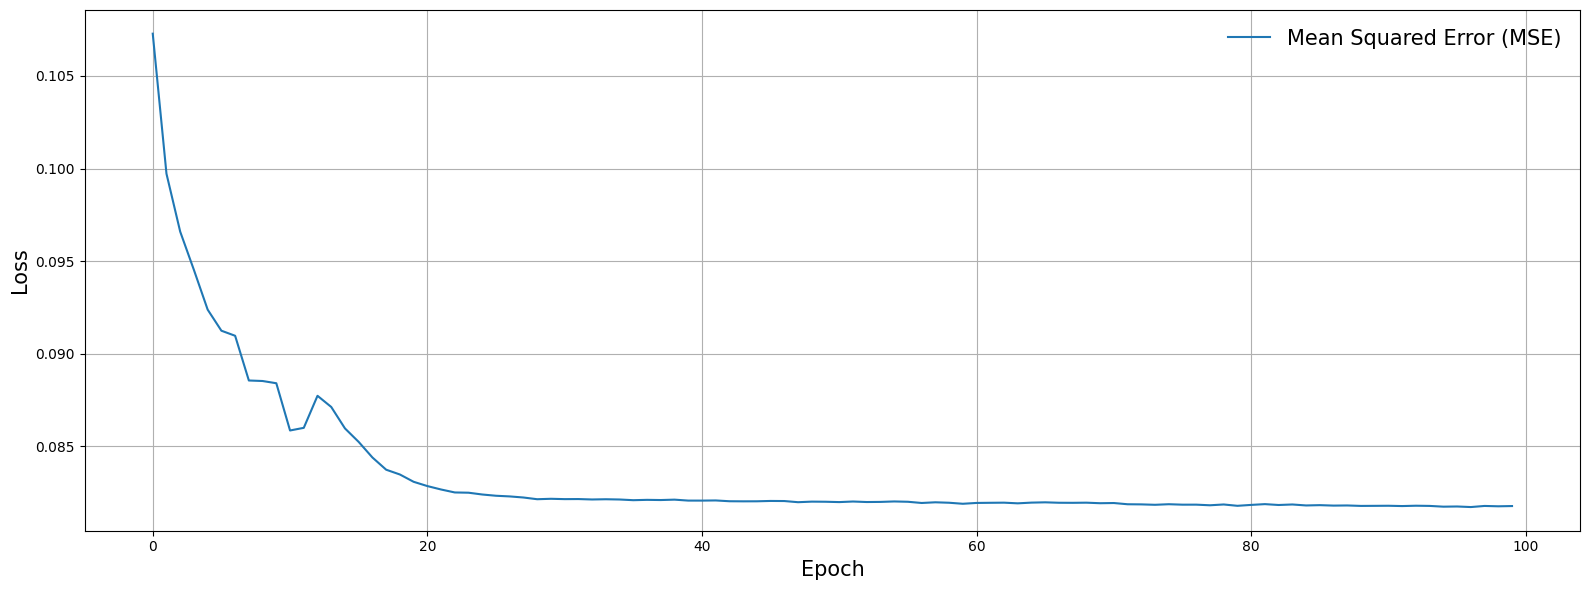

In [445]:
draw_metric_evolution(n_epochs = 100, loss_types = ['mse'], titles = ['Mean Squared Error (MSE)'])

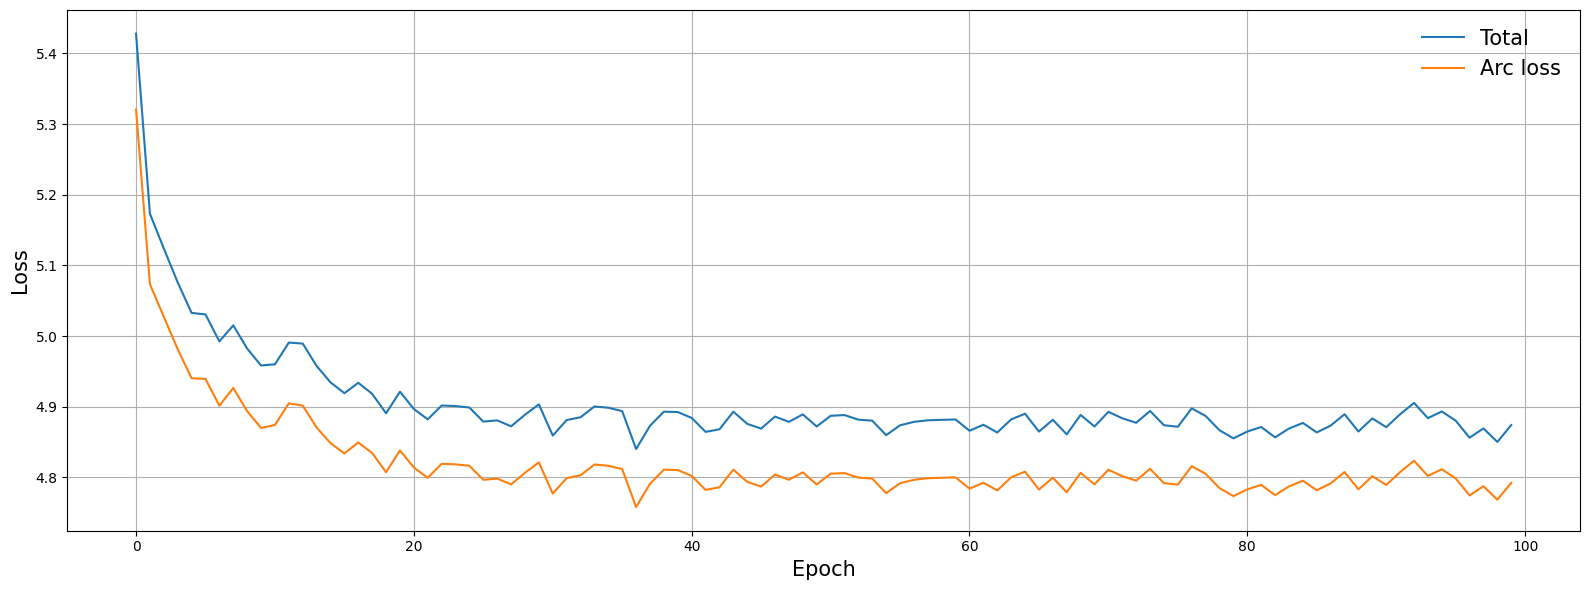

In [446]:
draw_metric_evolution(n_epochs = 100, loss_types = ['total', 'arc'], titles = ['Total', 'Arc loss'])

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

In [240]:
ae.mode = None

torch.Size([32, 1, 28, 28])


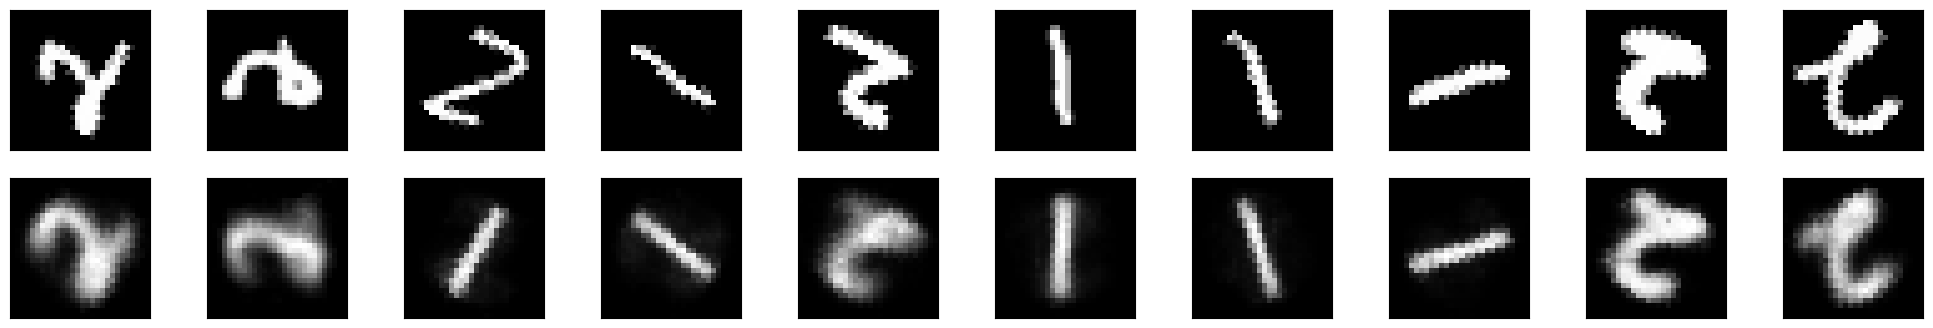

In [241]:
# obtain one batch of test images
batch = next(iter(test_loader))
x, _, _, y = batch

x = x.to(device)
# x_rot = x_rot.to(device)
# images_flatten = images.view(images.size(0), -1)

# get sample outputs
# output = model(images_flatten)
x_out = ae(x)


# x_out = x_out.detach().cpu().numpy()

print(x_out.shape)
# output is resized into a batch of images
# x_out = x_out.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad

x = x.detach().cpu().numpy()
x_out = x_out.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([x, x_out], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Now let's checkpoint our model, and move on.

In [239]:
torch.save(ae.state_dict(), "models/task_iii_e/Conv-AE-2-100-epochs.pt")

### Dataset distillation

Since my proposal will be for QMLHEP, I had to leave this sub-task out. Will be fun to revisit this afterwards, however!

### We'll need another dataset, since this a new task now. Our dataset will return us the latent representations from our trained VAE.

In [293]:
from torchvision.transforms.functional import rotate
from torch.utils.data import Dataset

class LatentRepresentationDataset(Dataset):
    """
        This class will return the raw-rotationed digit pairs in the VAE encoder latent space.
    """

    def __init__(self, x, gX, y):
        """
        Arguments:
            dataset: **has to be** our custom DiscreteRotationDataset with return_pairs = True.
            model: our trained VAE with get_latent = True.
        """
        self.x = x
        self.gX = gX
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        """
            each sample returned will consist of the original image
            and the rotated image latent representations.
        """
        return self.x[idx], self.gX[idx], self.y[idx]

In [297]:
from tqdm import tqdm

"""
    Here, we'll first load all latent representations from our trained AE.
    Then, we'll split in train/test and create our dataloaders.
"""
device = 'cuda'

ae = ae.to(device)

z_train = torch.tensor([]).to(device)
gX_z_train = torch.tensor([]).to(device)
y_train = torch.tensor([]).to(device)

z_test = torch.tensor([]).to(device)
gX_z_test = torch.tensor([]).to(device)
y_test = torch.tensor([]).to(device)

with torch.no_grad():
    for batch in tqdm(train_loader):
        x, gX, _, y = batch
        z_train = torch.cat((z_train, ae.enc(x.to(device))), axis=0)
        gX_z_train = torch.cat((gX_z_train, ae.enc(gX.to(device))), axis=0)
        y_train = torch.cat((y_train, y.to(device)), axis=0)
        
    for batch in tqdm(test_loader):
        x, gX, _, y = batch
        gX_z_test = torch.cat((gX_z_test, ae.enc(gX.to(device))), axis=0)
        y_test = torch.cat((y_test, y.to(device)), axis=0)

np.random.seed(42)
torch.manual_seed(42)
    
# z_train, z_test, y_train, y_test = train_test_split(latent, y, test_size=.25, shuffle=True)

z_train_dataset = LatentRepresentationDataset(z_train, gX_z_train, y_train)
z_test_dataset  = LatentRepresentationDataset(z_test, gX_z_test, y_test)

# Hyperparameters
num_epochs = 100
batch_size = 128
learning_rate = 1e-4

z_train_dataloader = torch.utils.data.DataLoader(z_train_dataset, batch_size=batch_size, shuffle=True)
z_test_dataloader  = torch.utils.data.DataLoader(z_test_dataset,  batch_size=batch_size, shuffle=True)

100%|██████████| 813/813 [00:10<00:00, 81.02it/s]


In [298]:
next(iter(z_train_dataloader))[0].shape

torch.Size([128, 2])

## Now, the latent representation classifier

In [244]:
class ZClassifier(nn.Module):
    
    def __init__(self):
        super(ZClassifier, self).__init__()

        # Encoder 
        self.layers = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x): 
        
        return torch.sigmoid(self.layers(x))

In [270]:
# oracle
z_clf = ZClassifier()
z_clf.to('cpu')

ZClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

### Let's train the oracle

In [170]:
torch.randn(30,1).squeeze(1).shape

torch.Size([30])

In [274]:
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(z_clf.parameters(), lr=1e-7)

device = 'cpu'

num_epochs = 3

loss_history = np.zeros((num_epochs, 2))

# Train the model
for epoch in range(num_epochs):
    
    train_loss = 0
    # print("Epoch: {}".format(epoch))
    for z_batch, _, y_batch in tqdm(z_train_dataloader):
        
        z_batch = z_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = criterion(z_clf(z_batch).squeeze(1), y_batch)
        train_loss += loss.item()*z_batch.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    test_loss = 0
    for z_batch, _, y_batch in tqdm(z_test_dataloader):
        
        z_batch = z_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = criterion(z_clf(z_batch).squeeze(1), y_batch)
        test_loss += loss.item()*z_batch.shape[0]
        
    loss_history[epoch, 0] = train_loss / z_train_dataloader.dataset.x.shape[0]
    loss_history[epoch, 1] = test_loss / z_test_dataloader.dataset.x.shape[0]

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_history[epoch,0]:.4f}, Val Loss: {loss_history[epoch,1]:.4f}",end='\r')

100%|██████████| 204/204 [00:00<00:00, 912.70it/s]


100%|██████████| 204/204 [00:00<00:00, 914.82it/s]


100%|██████████| 204/204 [00:00<00:00, 902.67it/s]

## And now, the infinitesimal operator

Starting with the loss

In [251]:
def normalized_dot(a,b):
    '''Given a_ij, b_ik returns a_ij b_ij / (|a_i|*|b_i|) (summed only over j!)
    This is equivalent to einsum('ik,jk', a, b).diag(), but avoids needlessly 
    computing the off diagonal elements. '''
    
    return torch.sum(a * b, dim=1) / (torch.norm(a, dim=1) * torch.norm(b, dim=1) + 1e-16)

def make_orthonormal(vecs):
    
    new_vecs = []

    def normalize(v):
        return v / torch.norm(v)

    for i, v in enumerate(vecs):

        #in_space_comp = torch.zeros((i, v.shape[0]))
        projections = [torch.zeros_like(v)]

        for j, w in enumerate(new_vecs[:i]):
            projections.append(v @ w * w)

        new_vecs.append(normalize(v - torch.stack(projections).sum(dim=0)))

    return torch.stack(new_vecs)


def get_nullspace_component(vec, basis):
    
    in_subspace_component = []
    
    for i, b in enumerate(basis):
        in_subspace_component.append(b * torch.dot(vec, b))
        
    return torch.norm(vec - torch.sum(torch.stack(in_subspace_component), dim=0))


def closure_loss(params):
    
    generators = [p for p in params]
    
    vecs = torch.flatten(torch.stack(generators), start_dim=1)
    basis = make_orthonormal(vecs)
    
    temp = [torch.tensor(0)]
    
    for i,j in combinations(range(len(generators)), 2):
        
        brac = bracket(generators[i], generators[j]).flatten()
        temp.append(get_nullspace_component(brac, basis)**2)
    
    return torch.sum(torch.stack(temp))


def ensemble_loss(inp, 
                  model, 
                  h_inv=1,
                  h_norm=1,
                  h_orth=0,
                  h_clos=0,
                  eps=1e-3,
                  return_components=False):

    transformed = model(inp, eps)
    
    loss_inv  = 0
    loss_norm = 0
    loss_orth = 0
    
    for x_tran in transformed:
        
        loss_inv  += torch.mean((oracle(inp) - oracle(x_tran))**2) / eps**2
        
        loss_norm += (torch.norm(x_tran - inp, dim=1).mean()/eps - 1)**2
        loss_norm += torch.norm(x_tran - inp, dim=1).std()/eps
    
    # Data-driven orthogonality loss
    for i,j in combinations(range(len(transformed)),2):
        
        loss_orth += torch.mean(normalized_dot(transformed[i]-inp, transformed[j]-inp)**2)

    loss_clos = 0 #closure_loss(model.parameters())
    
    # We have this option for debugging: 
    # If the loss isn't converging, this allows us to see which term is responsible
    if return_components:
        return (float(h_inv  * loss_inv ), 
                float(h_norm * loss_norm), 
                float(h_orth * loss_orth),
                float(h_clos * loss_clos))
     
    return (  h_inv  * loss_inv 
            + h_norm * loss_norm 
            + h_orth * loss_orth
            + h_clos * loss_clos)

and the generators:

In [252]:
class GeneratorModel(nn.Module):
    
    def __init__(self, n_dim=3, n_latent=16, n_generators=1):
        super(GeneratorModel, self).__init__()
        
        self.n_generators = n_generators
        
        W_list = [nn.Sequential(nn.Linear(n_dim, n_latent), 
                                nn.ReLU(),
                                nn.Linear(n_latent, n_dim))
                            for _ in range(n_generators)]
        
        
        self.W_list = nn.ModuleList(W_list)
        
    def forward(self, inp, epsilon=1e-3):
        
        outputs = []
        for i in range(self.n_generators):
            outputs.append(inp + epsilon * self.W_list[i](inp))
        
        return outputs

In [253]:
def oracle(x):
    return z_clf(x)

epoch 1100: Loss: 56.98564147949219                      
 Best Loss: 56.98564147949219 



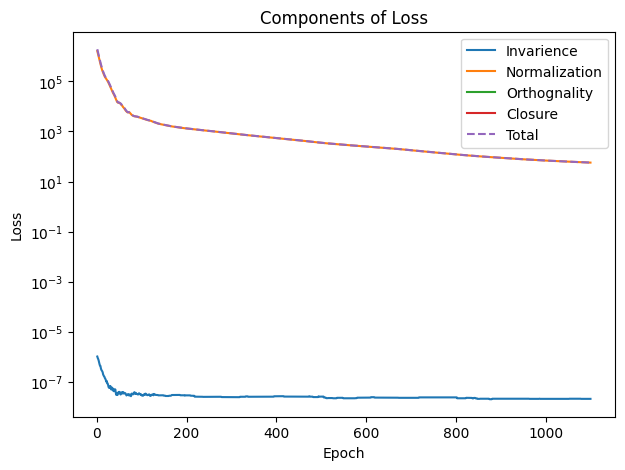

In [275]:
# the oracle
device = 'cuda'
z_train = z_train.to(device)
z_clf = z_clf.to(device)

y = z_clf(z_train)

np.random.seed(0)
torch.manual_seed(0)
generator = GeneratorModel(n_dim=2, n_latent=32).to(device)

# At this point you can use `model(dataset)` to get the transformed datasets.
# Though at this point the generators are just these random matricies:

# visualize_generators(model.parameters(), n_generators=n_generators)

# Hyperparameters
lr = .002
n_epochs = 1100
eps = 1e-5

h_inv  = 1
h_norm = 1
h_orth = 1
h_clos = 1

# Define the optimizer
optim = torch.optim.Adam(generator.parameters(), lr=lr)

# Keep track of some things
best_loss_so_far = np.inf
loss_history = []
loss_components = []

for epoch in range(1, n_epochs+1):

    # Gradient descent part:
    optim.zero_grad()

    loss = ensemble_loss(z_train, 
                         generator, 
                         h_inv=h_inv,
                         h_norm=h_norm,
                         h_orth=h_orth,
                         h_clos=h_clos,
                         eps=eps)
    loss.backward()
    optim.step()

    # Show and track progress:
    if epoch % 1 == 0:

        print(f'epoch {epoch}: Loss: {float(loss)}', ' '*20, end='\r')
        loss_history.append((epoch, float(loss)))
        loss_components.append((epoch, 
                                *ensemble_loss(z_train, generator,
                                               h_inv=h_inv,
                                               h_norm=h_norm,
                                               h_orth=h_orth,
                                               h_clos=h_clos,
                                               eps=eps,
                                               return_components=True)))

    # Keep track of best model so far:
    if loss < best_loss_so_far:
        best_loss_so_far = loss
        best_model       = copy.deepcopy(generator)
        best_model_epoch = epoch


else: print('\n', f'Best Loss: {best_loss_so_far} \n')

# ### Visualize the loss during the training process:

# I have broken the loss into the three parts:
#  - Invariance: (controlled by `h_inv`)
#  - Normalization: (controlled by `h_norm`)
#  - Closure: (controlled by `h_orth`)

loss_history = np.array(loss_history)
loss_components = np.array(loss_components)

plt.figure(figsize=[7,5], dpi=100)

plt.plot(loss_components[:,0], loss_components[:,1], label='Invarience')
plt.plot(loss_components[:,0], loss_components[:,2], label='Normalization')
plt.plot(loss_components[:,0], loss_components[:,3], label='Orthognality')
plt.plot(loss_components[:,0], loss_components[:,4], label='Closure')
plt.plot(loss_history[:,0], loss_history[:,1], ls='--', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

In [276]:
generator.to('cpu')
z_clf.to('cpu')

ZClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

[2.460464  2.43995   2.4194348 2.3989203 2.3784053]


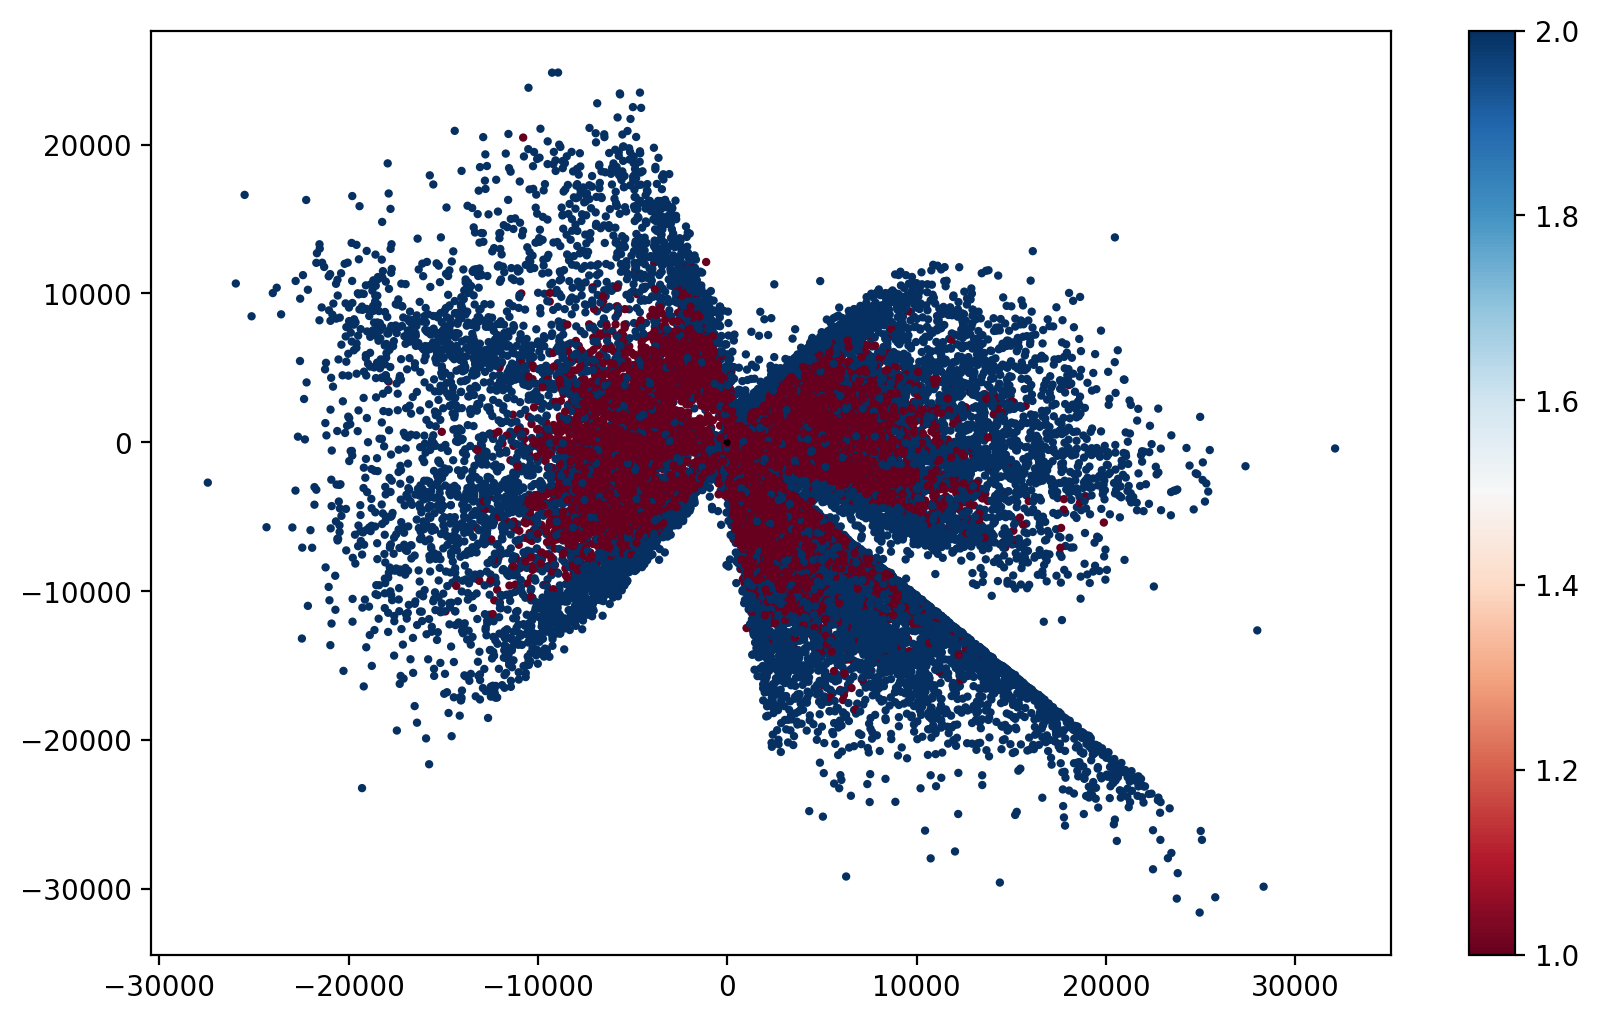

In [278]:
print(grid_preds[:5])

device = 'cpu'

X_vec, Y_vec = np.meshgrid(np.linspace(-40,20,30), np.linspace(-30,10,30))
vec_grid_points = torch.tensor(np.stack([X_vec.flatten(), Y_vec.flatten()]).T).float()

vec_grid = generator.W_list[0](vec_grid_points.to(device)).cpu().detach().numpy()

plt.figure(figsize=[10,6], dpi=200)
plt.contourf(X, Y, grid_preds.reshape((100,100)), 30, cmap='RdBu', vmin=-40, vmax=40)
plt.scatter(*z_test.cpu().detach().numpy().T, c=y_test.cpu().detach().numpy(), s=4, cmap='RdBu', alpha=1)
# plt.axis([-40,20,-30,10])
for p,v in zip(vec_grid_points, vec_grid):
    plt.arrow(*p, *(v*1), head_width=.2, color='k')
plt.colorbar()

## Finally, let's try our infinitesimal generator..

In [279]:
# my_z = torch.tensor([ -6.7115, -16.4715]) #z_test[360]
my_z = z_train[0] #torch.tensor([ -6.7115, -18]) #z_test[360]

path_history1 = [my_z.cpu().detach().numpy()]

for i in tqdm(range(1,25000)):
    my_z = generator(my_z.to(device))[0].detach()
    
    if i%100==0:
        path_history1.append(my_z.cpu().detach().numpy())
    
path_history1 = np.array(path_history1)

100%|██████████| 24999/24999 [00:01<00:00, 14826.69it/s]


In [265]:
ae = ae.to(device)

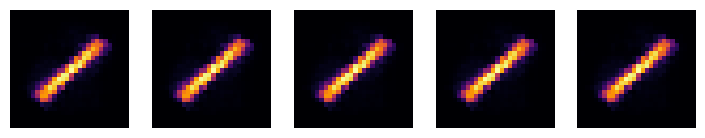

In [280]:
plt.figure(figsize=[18,4])

ll = 10

for i, im in enumerate(ae.dec(torch.tensor(path_history1[::50]).to(device))):
    plt.subplot(1,ll,i+1)
    plt.imshow(im.cpu().detach().numpy().squeeze(), cmap='inferno')
    plt.axis('off')

Unfortunately, this approach didn't work, but it probably is due to the uncleaned samples, as I had to skip the distillation. 

Nevertheless, I could find the infinitesimal operator in the LieGAN

## Now, the LieGAN

In [299]:
"""
This is the official implementation taken from the paper. 

See more at: https://github.com/Rose-STL-Lab/LieGAN/blob/master/gan.py

"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import *


class LieGenerator(nn.Module):
    def __init__(self, n_dim, n_channel, args):
        super(LieGenerator, self).__init__()
        self.n_dim = n_dim
        self.n_channel = n_channel
        self.args = args
        self.sigma = nn.Parameter(torch.eye(n_channel, n_channel) * args['sigma_init'])
        self.mu = nn.Parameter(torch.zeros(n_channel))
        self.uniform_max = args['uniform_max']
        self.dummy_pos = None
        self.l0reg = False
        self.activated_channel = None  # default to all channel
        if args['g_init'] == 'random':
            self.Li = nn.Parameter(torch.randn(n_channel, n_dim, n_dim))
            nn.init.kaiming_normal_(self.Li)
        elif args['g_init'] == 'zero':
            self.Li = nn.Parameter(torch.zeros(n_channel, n_dim, n_dim))

    def set_activated_channel(self, ch):
        self.activated_channel = ch

    def activate_all_channels(self):
        self.activated_channel = None

    def normalize_factor(self):
        trace = torch.einsum('kdf,kdf->k', self.Li, self.Li)
        factor = torch.sqrt(trace / self.Li.shape[1])
        return factor.unsqueeze(-1).unsqueeze(-1)

    def normalize_L(self):
        return self.Li / (self.normalize_factor() + 1e-6)

    def channel_corr(self, killing=False):
        Li = self.normalize_L()
        if not killing:
            ch = self.activated_channel
            if ch is None:
                return torch.sum(torch.abs(torch.triu(torch.einsum('bij,cij->bc', Li, Li), diagonal=1)))
            else:
                return torch.sum(torch.abs(torch.triu(torch.einsum('bij,cij->bc', Li, Li), diagonal=1))[:(ch+1), :(ch+1)])
        else:
            trxy = torch.triu(torch.einsum('bij,cji->bc', Li, Li), diagonal=1)
            trx = torch.einsum('kdd->k', Li)
            trx_try = torch.triu(torch.einsum('b,c->bc', trx, trx), diagonal=1)
            return torch.sum(torch.abs(trxy - 1 / self.n_dim * trx_try))  # sum of tr(XY)-tr(X)tr(Y)/n, i.e. B(X,Y)/2n

    def forward(self, x, y):  # random transformation on x
        # x: (batch_size, n_components, n_dim); y: (batch_size, n_components_y, n_dim)
        if len(x.shape) == 2:
            x.unsqueeze_(1)
        if len(y.shape) == 2:
            y.unsqueeze_(1)
        batch_size = x.shape[0]
        z = self.sample_coefficient(batch_size, x.device)
        Li = self.normalize_L() if self.args['normalize_Li'] else self.Li
        if self.args['g_init'] in ['2*2_factorization', '4*4_factorization', ]:
            g_z = torch.matrix_exp(torch.einsum('bj,jkl->bkl', z, Li * self.mask.to(x.device)))
        else:
            g_z = torch.matrix_exp(torch.einsum('bj,jkl->bkl', z, Li))
        x_t = self.transform(g_z, x, self.args['x_type'])
        y_t = self.transform(g_z, y, self.args['y_type'])
        return x_t, y_t

    def sample_coefficient(self, batch_size, device):
        if self.args['coef_dist'] == 'normal':
            z = torch.randn(batch_size, self.n_channel, device=device) @ self.sigma + self.mu
        elif self.args['coef_dist'] == 'uniform':
            z = torch.rand(batch_size, self.n_channel, device=device) * 2 * self.uniform_max - self.uniform_max
        elif self.args['coef_dist'] == 'uniform_int_grid':
            z = torch.randint(-int(self.uniform_max), int(self.uniform_max), (batch_size, self.n_channel), device=device, dtype=torch.float32)
        ch = self.activated_channel
        if ch is not None:  # leaving only specified columns
            mask = torch.zeros_like(z, device=z.device)
            mask[:, ch] = 1
            z = z * mask
        return z
    
    def transform(self, g_z, x, tp):
        if tp == 'vector':
            return affine_coord(torch.einsum('bjk,btk->btj', g_z, x), self.dummy_pos)
        elif tp == 'scalar':
            return x

    def getLi(self):
        if self.args['g_init'] in ['2*2_factorization', '4*4_factorization', ]:
            return self.Li * self.mask.to(self.Li.device)
        else:
            return self.Li


class LieDiscriminator(nn.Module):
    def __init__(self, input_size):
        super(LieDiscriminator, self).__init__()
        self.input_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
        xy = torch.cat((x, y), dim=1)
        validity = self.model(xy)
        return validity

### We need a training function

In [304]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import os
import math
from collections.abc import Iterable
from tqdm import tqdm, trange
from utils import *

def train_lie_gan(
    generator,
    discriminator,
    dataloader,
    num_epochs,
    lr_d,
    lr_g,
    reg_type,
    lamda,
    p_norm,
    mu,
    eta,
    device,
    task='clf',
    save_path=None,
    print_every=100,
):
    # Loss function
    adversarial_loss = torch.nn.BCELoss(reduction='mean')
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d)
    train_generator = train_discriminator = True

    for ep in trange(num_epochs):
        D_real_loss_list, D_fake_loss_list, G_loss_list, G_reg_list, G_spreg_list, G_chreg_list = [], [], [], [], [], []
        for i, (x, y, _) in enumerate(dataloader):
            bs = x.shape[0]
            # Adversarial ground truths
            valid = torch.ones(bs, 1, device=device)
            fake = torch.zeros(bs, 1, device=device)
            # Configure input
            x = x.to(device)
            y = y.to(device)
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            # Generate a batch of transformed data points
            gx, gy = generator(x, y)
            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gx, gy), valid)
            g_spreg = mu * torch.norm(generator.getLi(), p=p_norm)
            if reg_type == 'cosine':
                g_reg = torch.abs(nn.CosineSimilarity(dim=2)(gx, x).mean())
            elif reg_type == 'rel_diff':
                g_reg = -torch.minimum(torch.abs((gx - x) / x).mean(), torch.FloatTensor([1.0]).to(device))
            elif reg_type == 'Li_norm':
                g_reg = -torch.minimum(torch.norm(generator.getLi(), p=2, dim=None), torch.FloatTensor([generator.n_dim * generator.n_channel]).to(device))
            else:
                raise NotImplementedError
            g_reg = lamda * g_reg
            g_chreg = eta * generator.channel_corr(killing=False)
            G_loss_list.append(g_loss.item())
            G_reg_list.append(g_reg.item() / max(lamda, 1e-6))
            G_spreg_list.append(g_spreg.item() / max(mu, 1e-6))
            G_chreg_list.append(g_chreg.item() / max(eta, 1e-6))
            g_loss = g_loss + g_reg + g_spreg + g_chreg
            if train_generator:
                g_loss.backward()
                optimizer_G.step()
            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(x, y), valid)
            fake_loss = adversarial_loss(discriminator(gx.detach(), gy.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            if train_discriminator:
                d_loss.backward()
                optimizer_D.step()
            D_real_loss_list.append(real_loss.item())
            D_fake_loss_list.append(fake_loss.item())
        if save_path is not None and (ep + 1) % 100 == 0:
            if not os.path.isdir(save_path):
                os.mkdir(save_path)
            torch.save(generator.state_dict(), save_path + f'generator_{ep}.pt')
            torch.save(discriminator.state_dict(), save_path + f'discriminator_{ep}.pt')
        if (ep + 1) % print_every == 0:
            print(f'Epoch {ep}: D_real_loss={np.mean(D_real_loss_list)}, D_fake_loss={np.mean(D_fake_loss_list)}, G_loss={np.mean(G_loss_list)}, G_reg={np.mean(G_reg_list)}, G_spreg={np.mean(G_spreg_list)}, G_chreg={np.mean(G_chreg_list)}')
            print(generator.getLi())

#### Even though we need 1 generator for so(2), since we don't know what is the symmetry in the latent space, I chose 3 generators

In [307]:
# dataset = DiscreteRotation(N=args.dataset_size)
n_channel = 3
n_dim = 2 #ae(images_flatten)[1].shape[1]
d_input_size = 2*n_dim

default_args = {
    'batch_size': batch_size,
    'num_epochs': 100,
    'lr_d': 2e-4,
    'lr_g': 1e-3,
    'reg_type': 'cosine',
    'lamda': 1e-2,
    'p_norm': 2,
    'droprate_init': 0.8,
    'mu': 0.0,
    'activate_threshold': False,  # store_true means default is False
    'D_loss_threshold': 0.25,
    'model': 'lie',
    'coef_dist': 'normal',
    'g_init': 'random',
    'sigma_init': 1,
    'uniform_max': 1,
    'normalize_Li': False,  # store_true means default is False
    'augment': False,  # store_true means default is False
    'n_channel': 1,
    'eta': 1.0,
    'incremental': False,  # store_true means default is False
    'dataset_size': len(z_train_dataloader.dataset),
    'x_type': 'vector',
    'y_type': 'vector',
    'input_timesteps': 1,
    'output_timesteps': 1,
    'n_component': 1,
    'noise': 0.0,
    'seed': 42,
    'gpu': 0,
    'print_every': 1,
    'save_path': 'models/task_iii_e/',
    'save_name': 'lieGAN'
}

generator = LieGenerator(n_dim, n_channel, default_args).to(device)
discriminator = LieDiscriminator(d_input_size).to(device)

# fix the coefficient distribution
generator.mu.requires_grad = False
generator.sigma.requires_grad = False
# elif args.model == 'lie_subgrp':  # fix the generator
#     generator.Li.requires_grad = False

In [302]:
d_input_size

4

In [308]:
mu = 0.0
reg_type = 'cosine'
lr_d = 2e-4
lr_g = 1e-3
lamda = 1e-2
p_norm = 2.0
eta = 1.0
device = 'cuda'

# Set random seed
torch.manual_seed(42)
np.random.seed(42)


train_lie_gan(
    generator,
    discriminator,
    z_train_dataloader,
    default_args['num_epochs'],
    default_args['lr_d'],
    default_args['lr_g'],
    default_args['reg_type'],
    default_args['lamda'],
    default_args['p_norm'],
    default_args['mu'],
    default_args['eta'],
    device,
    save_path="models/task_iii_e/",
    print_every=1,
)

  1%|          | 1/100 [00:22<36:29, 22.11s/it]

Epoch 0: D_real_loss=0.910862130067592, D_fake_loss=98.38552603413336, G_loss=1.5510612210931762, G_reg=0.7346996331413838, G_spreg=0.0, G_chreg=2.1617972974663116
Parameter containing:
tensor([[[-0.3818,  0.8168],
         [ 0.7362,  0.9155]],

        [[-0.5713, -0.7233],
         [ 0.9005,  0.1766]],

        [[-0.3031,  0.3078],
         [ 0.1596, -0.5291]]], device='cuda:0', requires_grad=True)


  2%|▏         | 2/100 [00:43<35:53, 21.98s/it]

Epoch 1: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6918532421967245, G_spreg=0.0, G_chreg=0.04462059693587717
Parameter containing:
tensor([[[-0.2966,  0.9369],
         [ 0.6493,  0.9111]],

        [[-0.5314, -0.8202],
         [ 0.8421,  0.0686]],

        [[-0.3013,  0.3119],
         [ 0.1578, -0.5303]]], device='cuda:0', requires_grad=True)


  3%|▎         | 3/100 [01:05<35:25, 21.92s/it]

Epoch 2: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6881004094211095, G_spreg=0.0, G_chreg=0.0035173061149746904
Parameter containing:
tensor([[[-0.2969,  0.9371],
         [ 0.6496,  0.9120]],

        [[-0.5309, -0.8222],
         [ 0.8458,  0.0691]],

        [[-0.3014,  0.3127],
         [ 0.1574, -0.5322]]], device='cuda:0', requires_grad=True)


  4%|▍         | 4/100 [01:27<35:04, 21.92s/it]

Epoch 3: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6890250978667655, G_spreg=0.0, G_chreg=0.003424762365800007
Parameter containing:
tensor([[[-0.2974,  0.9382],
         [ 0.6498,  0.9122]],

        [[-0.5306, -0.8242],
         [ 0.8501,  0.0694]],

        [[-0.3022,  0.3137],
         [ 0.1577, -0.5333]]], device='cuda:0', requires_grad=True)


  5%|▌         | 5/100 [01:49<34:36, 21.86s/it]

Epoch 4: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6862980031309059, G_spreg=0.0, G_chreg=0.0038927197081015754
Parameter containing:
tensor([[[-0.2972,  0.9393],
         [ 0.6493,  0.9133]],

        [[-0.5309, -0.8264],
         [ 0.8547,  0.0685]],

        [[-0.3036,  0.3136],
         [ 0.1585, -0.5350]]], device='cuda:0', requires_grad=True)


  6%|▌         | 6/100 [02:11<34:19, 21.91s/it]

Epoch 5: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6860040633772647, G_spreg=0.0, G_chreg=0.004193500078445118
Parameter containing:
tensor([[[-0.2982,  0.9408],
         [ 0.6499,  0.9129]],

        [[-0.5309, -0.8284],
         [ 0.8599,  0.0683]],

        [[-0.3050,  0.3149],
         [ 0.1594, -0.5355]]], device='cuda:0', requires_grad=True)


  7%|▋         | 7/100 [02:33<33:57, 21.91s/it]

Epoch 6: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6850042371008949, G_spreg=0.0, G_chreg=0.0041052329750445385
Parameter containing:
tensor([[[-0.2980,  0.9415],
         [ 0.6498,  0.9142]],

        [[-0.5305, -0.8305],
         [ 0.8643,  0.0682]],

        [[-0.3055,  0.3155],
         [ 0.1593, -0.5377]]], device='cuda:0', requires_grad=True)


  8%|▊         | 8/100 [02:55<33:30, 21.85s/it]

Epoch 7: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6813262617035661, G_spreg=0.0, G_chreg=0.0043612268106663155
Parameter containing:
tensor([[[-0.2989,  0.9424],
         [ 0.6506,  0.9144]],

        [[-0.5301, -0.8324],
         [ 0.8687,  0.0690]],

        [[-0.3062,  0.3171],
         [ 0.1594, -0.5391]]], device='cuda:0', requires_grad=True)


  9%|▉         | 9/100 [03:17<33:10, 21.87s/it]

Epoch 8: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6794350967749541, G_spreg=0.0, G_chreg=0.004521254506384396
Parameter containing:
tensor([[[-0.2982,  0.9440],
         [ 0.6500,  0.9157]],

        [[-0.5298, -0.8347],
         [ 0.8727,  0.0682]],

        [[-0.3070,  0.3174],
         [ 0.1594, -0.5414]]], device='cuda:0', requires_grad=True)


 10%|█         | 10/100 [03:38<32:48, 21.88s/it]

Epoch 9: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6780603907980481, G_spreg=0.0, G_chreg=0.004232862809443054
Parameter containing:
tensor([[[-0.2980,  0.9452],
         [ 0.6498,  0.9166]],

        [[-0.5291, -0.8372],
         [ 0.8770,  0.0680]],

        [[-0.3077,  0.3187],
         [ 0.1596, -0.5431]]], device='cuda:0', requires_grad=True)


 11%|█         | 11/100 [04:00<32:23, 21.84s/it]

Epoch 10: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6772116460781904, G_spreg=0.0, G_chreg=0.004393267969966035
Parameter containing:
tensor([[[-0.2988,  0.9459],
         [ 0.6505,  0.9171]],

        [[-0.5293, -0.8389],
         [ 0.8824,  0.0679]],

        [[-0.3087,  0.3204],
         [ 0.1600, -0.5445]]], device='cuda:0', requires_grad=True)


 12%|█▏        | 12/100 [04:22<32:03, 21.86s/it]

Epoch 11: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6760347251781114, G_spreg=0.0, G_chreg=0.004132285911205133
Parameter containing:
tensor([[[-0.2985,  0.9473],
         [ 0.6500,  0.9178]],

        [[-0.5295, -0.8412],
         [ 0.8871,  0.0668]],

        [[-0.3103,  0.3203],
         [ 0.1608, -0.5463]]], device='cuda:0', requires_grad=True)


 13%|█▎        | 13/100 [04:44<31:39, 21.83s/it]

Epoch 12: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6748006918790533, G_spreg=0.0, G_chreg=0.003910271555660754
Parameter containing:
tensor([[[-0.2997,  0.9482],
         [ 0.6506,  0.9179]],

        [[-0.5288, -0.8437],
         [ 0.8921,  0.0674]],

        [[-0.3109,  0.3218],
         [ 0.1609, -0.5475]]], device='cuda:0', requires_grad=True)


 14%|█▍        | 14/100 [05:06<31:13, 21.79s/it]

Epoch 13: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6720987373398418, G_spreg=0.0, G_chreg=0.004301225133146387
Parameter containing:
tensor([[[-0.3001,  0.9496],
         [ 0.6504,  0.9182]],

        [[-0.5283, -0.8463],
         [ 0.8966,  0.0674]],

        [[-0.3121,  0.3228],
         [ 0.1613, -0.5490]]], device='cuda:0', requires_grad=True)


 15%|█▌        | 15/100 [05:27<30:53, 21.80s/it]

Epoch 14: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6723472077515223, G_spreg=0.0, G_chreg=0.002911143098730284
Parameter containing:
tensor([[[-0.3004,  0.9500],
         [ 0.6505,  0.9191]],

        [[-0.5284, -0.8478],
         [ 0.9010,  0.0671]],

        [[-0.3129,  0.3227],
         [ 0.1615, -0.5506]]], device='cuda:0', requires_grad=True)


 16%|█▌        | 16/100 [05:49<30:30, 21.79s/it]

Epoch 15: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.669628760865776, G_spreg=0.0, G_chreg=0.0036655786899985835
Parameter containing:
tensor([[[-0.3007,  0.9512],
         [ 0.6499,  0.9191]],

        [[-0.5275, -0.8506],
         [ 0.9047,  0.0669]],

        [[-0.3138,  0.3237],
         [ 0.1617, -0.5518]]], device='cuda:0', requires_grad=True)


 17%|█▋        | 17/100 [06:11<30:10, 21.81s/it]

Epoch 16: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6683928136636388, G_spreg=0.0, G_chreg=0.0040900734551157095
Parameter containing:
tensor([[[-0.3010,  0.9519],
         [ 0.6500,  0.9199]],

        [[-0.5270, -0.8529],
         [ 0.9096,  0.0669]],

        [[-0.3146,  0.3243],
         [ 0.1619, -0.5536]]], device='cuda:0', requires_grad=True)


 18%|█▊        | 18/100 [06:33<29:50, 21.84s/it]

Epoch 17: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6663289251107813, G_spreg=0.0, G_chreg=0.004346302190465551
Parameter containing:
tensor([[[-0.3019,  0.9530],
         [ 0.6507,  0.9199]],

        [[-0.5270, -0.8548],
         [ 0.9149,  0.0666]],

        [[-0.3158,  0.3258],
         [ 0.1625, -0.5547]]], device='cuda:0', requires_grad=True)


 19%|█▉        | 19/100 [06:55<29:29, 21.84s/it]

Epoch 18: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6659050106511183, G_spreg=0.0, G_chreg=0.00451971164190599
Parameter containing:
tensor([[[-0.3023,  0.9543],
         [ 0.6505,  0.9204]],

        [[-0.5267, -0.8575],
         [ 0.9197,  0.0663]],

        [[-0.3167,  0.3266],
         [ 0.1628, -0.5563]]], device='cuda:0', requires_grad=True)


 20%|██        | 20/100 [07:17<29:09, 21.86s/it]

Epoch 19: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6632380857266091, G_spreg=0.0, G_chreg=0.004144119072195665
Parameter containing:
tensor([[[-0.3023,  0.9548],
         [ 0.6507,  0.9217]],

        [[-0.5265, -0.8596],
         [ 0.9251,  0.0663]],

        [[-0.3176,  0.3266],
         [ 0.1629, -0.5585]]], device='cuda:0', requires_grad=True)


 21%|██        | 21/100 [07:39<28:47, 21.87s/it]

Epoch 20: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.662903114175854, G_spreg=0.0, G_chreg=0.0034800455017964644
Parameter containing:
tensor([[[-0.3027,  0.9564],
         [ 0.6504,  0.9217]],

        [[-0.5259, -0.8621],
         [ 0.9292,  0.0661]],

        [[-0.3185,  0.3276],
         [ 0.1632, -0.5594]]], device='cuda:0', requires_grad=True)


 22%|██▏       | 22/100 [08:00<28:22, 21.83s/it]

Epoch 21: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6589424450382102, G_spreg=0.0, G_chreg=0.003076133697499356
Parameter containing:
tensor([[[-0.3030,  0.9569],
         [ 0.6505,  0.9222]],

        [[-0.5259, -0.8637],
         [ 0.9337,  0.0659]],

        [[-0.3195,  0.3278],
         [ 0.1636, -0.5608]]], device='cuda:0', requires_grad=True)


 23%|██▎       | 23/100 [08:22<28:03, 21.86s/it]

Epoch 22: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6578674677940826, G_spreg=0.0, G_chreg=0.003167239362631997
Parameter containing:
tensor([[[-0.3033,  0.9579],
         [ 0.6498,  0.9223]],

        [[-0.5252, -0.8665],
         [ 0.9377,  0.0657]],

        [[-0.3202,  0.3286],
         [ 0.1637, -0.5619]]], device='cuda:0', requires_grad=True)


 24%|██▍       | 24/100 [08:44<27:42, 21.87s/it]

Epoch 23: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6540952815332526, G_spreg=0.0, G_chreg=0.003365289626328711
Parameter containing:
tensor([[[-0.3040,  0.9583],
         [ 0.6498,  0.9230]],

        [[-0.5247, -0.8690],
         [ 0.9430,  0.0657]],

        [[-0.3206,  0.3291],
         [ 0.1638, -0.5636]]], device='cuda:0', requires_grad=True)


 25%|██▌       | 25/100 [09:06<27:19, 21.86s/it]

Epoch 24: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6537143600436818, G_spreg=0.0, G_chreg=0.003565044759277733
Parameter containing:
tensor([[[-0.3047,  0.9596],
         [ 0.6496,  0.9231]],

        [[-0.5243, -0.8718],
         [ 0.9482,  0.0651]],

        [[-0.3216,  0.3300],
         [ 0.1643, -0.5645]]], device='cuda:0', requires_grad=True)


 26%|██▌       | 26/100 [09:28<26:57, 21.86s/it]

Epoch 25: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6517156341999119, G_spreg=0.0, G_chreg=0.004088303535601154
Parameter containing:
tensor([[[-0.3051,  0.9600],
         [ 0.6499,  0.9241]],

        [[-0.5241, -0.8740],
         [ 0.9539,  0.0652]],

        [[-0.3221,  0.3306],
         [ 0.1642, -0.5664]]], device='cuda:0', requires_grad=True)


 27%|██▋       | 27/100 [09:50<26:36, 21.86s/it]

Epoch 26: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6513894822192007, G_spreg=0.0, G_chreg=0.004139220421800685
Parameter containing:
tensor([[[-0.3059,  0.9615],
         [ 0.6502,  0.9239]],

        [[-0.5243, -0.8761],
         [ 0.9595,  0.0643]],

        [[-0.3237,  0.3315],
         [ 0.1653, -0.5672]]], device='cuda:0', requires_grad=True)


 28%|██▊       | 28/100 [10:11<26:12, 21.84s/it]

Epoch 27: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6494930608700069, G_spreg=0.0, G_chreg=0.003909703600591816
Parameter containing:
tensor([[[-0.3062,  0.9629],
         [ 0.6500,  0.9243]],

        [[-0.5231, -0.8792],
         [ 0.9641,  0.0647]],

        [[-0.3241,  0.3327],
         [ 0.1650, -0.5685]]], device='cuda:0', requires_grad=True)


 29%|██▉       | 29/100 [10:33<25:51, 21.85s/it]

Epoch 28: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6470490646205286, G_spreg=0.0, G_chreg=0.0035310520889827125
Parameter containing:
tensor([[[-0.3060,  0.9633],
         [ 0.6501,  0.9255]],

        [[-0.5232, -0.8811],
         [ 0.9694,  0.0644]],

        [[-0.3250,  0.3325],
         [ 0.1652, -0.5706]]], device='cuda:0', requires_grad=True)


 30%|███       | 30/100 [10:55<25:27, 21.82s/it]

Epoch 29: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6460912935404494, G_spreg=0.0, G_chreg=0.0031268339006716617
Parameter containing:
tensor([[[-0.3064,  0.9650],
         [ 0.6497,  0.9253]],

        [[-0.5225, -0.8834],
         [ 0.9729,  0.0642]],

        [[-0.3258,  0.3337],
         [ 0.1654, -0.5712]]], device='cuda:0', requires_grad=True)


 31%|███       | 31/100 [11:17<25:07, 21.85s/it]

Epoch 30: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6435130406515149, G_spreg=0.0, G_chreg=0.003159307256203354
Parameter containing:
tensor([[[-0.3067,  0.9652],
         [ 0.6498,  0.9259]],

        [[-0.5220, -0.8854],
         [ 0.9774,  0.0647]],

        [[-0.3262,  0.3342],
         [ 0.1652, -0.5729]]], device='cuda:0', requires_grad=True)


 32%|███▏      | 32/100 [11:39<24:50, 21.93s/it]

Epoch 31: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6428691188669525, G_spreg=0.0, G_chreg=0.0034904977718038183
Parameter containing:
tensor([[[-0.3070,  0.9664],
         [ 0.6492,  0.9261]],

        [[-0.5216, -0.8881],
         [ 0.9821,  0.0639]],

        [[-0.3275,  0.3347],
         [ 0.1659, -0.5738]]], device='cuda:0', requires_grad=True)


 33%|███▎      | 33/100 [12:01<24:24, 21.86s/it]

Epoch 32: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6409033615686356, G_spreg=0.0, G_chreg=0.0035066724286471765
Parameter containing:
tensor([[[-0.3073,  0.9669],
         [ 0.6493,  0.9269]],

        [[-0.5211, -0.8905],
         [ 0.9874,  0.0639]],

        [[-0.3280,  0.3351],
         [ 0.1658, -0.5754]]], device='cuda:0', requires_grad=True)


 34%|███▍      | 34/100 [12:23<24:04, 21.88s/it]

Epoch 33: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.638397940255445, G_spreg=0.0, G_chreg=0.003664228661684906
Parameter containing:
tensor([[[-0.3077,  0.9684],
         [ 0.6490,  0.9270]],

        [[-0.5207, -0.8933],
         [ 0.9925,  0.0632]],

        [[-0.3290,  0.3360],
         [ 0.1663, -0.5762]]], device='cuda:0', requires_grad=True)


 35%|███▌      | 35/100 [12:45<23:43, 21.90s/it]

Epoch 34: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6380492203972927, G_spreg=0.0, G_chreg=0.003986943922905638
Parameter containing:
tensor([[[-0.3081,  0.9690],
         [ 0.6494,  0.9278]],

        [[-0.5205, -0.8954],
         [ 0.9983,  0.0633]],

        [[-0.3296,  0.3365],
         [ 0.1663, -0.5780]]], device='cuda:0', requires_grad=True)


 36%|███▌      | 36/100 [13:07<23:19, 21.87s/it]

Epoch 35: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6342656695378568, G_spreg=0.0, G_chreg=0.0033633934629503964
Parameter containing:
tensor([[[-0.3085,  0.9698],
         [ 0.6497,  0.9282]],

        [[-0.5203, -0.8973],
         [ 1.0032,  0.0632]],

        [[-0.3306,  0.3371],
         [ 0.1666, -0.5793]]], device='cuda:0', requires_grad=True)


 37%|███▋      | 37/100 [13:28<22:57, 21.86s/it]

Epoch 36: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6351371285975554, G_spreg=0.0, G_chreg=0.003337478764061163
Parameter containing:
tensor([[[-0.3087,  0.9703],
         [ 0.6500,  0.9290]],

        [[-0.5199, -0.8990],
         [ 1.0076,  0.0639]],

        [[-0.3311,  0.3377],
         [ 0.1664, -0.5809]]], device='cuda:0', requires_grad=True)


 38%|███▊      | 38/100 [13:50<22:35, 21.86s/it]

Epoch 37: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6311430951219137, G_spreg=0.0, G_chreg=0.0038828472821878647
Parameter containing:
tensor([[[-0.3089,  0.9723],
         [ 0.6498,  0.9289]],

        [[-0.5195, -0.9013],
         [ 1.0121,  0.0631]],

        [[-0.3325,  0.3386],
         [ 0.1670, -0.5818]]], device='cuda:0', requires_grad=True)


 39%|███▉      | 39/100 [14:12<22:13, 21.85s/it]

Epoch 38: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6294741971288454, G_spreg=0.0, G_chreg=0.003881578869323186
Parameter containing:
tensor([[[-0.3096,  0.9738],
         [ 0.6501,  0.9291]],

        [[-0.5192, -0.9034],
         [ 1.0173,  0.0632]],

        [[-0.3337,  0.3395],
         [ 0.1674, -0.5829]]], device='cuda:0', requires_grad=True)


 40%|████      | 40/100 [14:34<21:52, 21.87s/it]

Epoch 39: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6271959865023167, G_spreg=0.0, G_chreg=0.003376323335642178
Parameter containing:
tensor([[[-0.3093,  0.9750],
         [ 0.6496,  0.9300]],

        [[-0.5186, -0.9064],
         [ 1.0228,  0.0628]],

        [[-0.3345,  0.3398],
         [ 0.1676, -0.5847]]], device='cuda:0', requires_grad=True)


 41%|████      | 41/100 [14:56<21:30, 21.88s/it]

Epoch 40: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.625213868697084, G_spreg=0.0, G_chreg=0.003372804128027683
Parameter containing:
tensor([[[-0.3092,  0.9756],
         [ 0.6495,  0.9311]],

        [[-0.5179, -0.9093],
         [ 1.0289,  0.0629]],

        [[-0.3348,  0.3401],
         [ 0.1672, -0.5865]]], device='cuda:0', requires_grad=True)


 42%|████▏     | 42/100 [15:18<21:05, 21.82s/it]

Epoch 41: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6235760598311296, G_spreg=0.0, G_chreg=0.0032853350625080186
Parameter containing:
tensor([[[-0.3098,  0.9771],
         [ 0.6493,  0.9310]],

        [[-0.5178, -0.9120],
         [ 1.0347,  0.0622]],

        [[-0.3363,  0.3406],
         [ 0.1681, -0.5870]]], device='cuda:0', requires_grad=True)


 43%|████▎     | 43/100 [15:39<20:44, 21.84s/it]

Epoch 42: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6237439883952627, G_spreg=0.0, G_chreg=0.004048006551216672
Parameter containing:
tensor([[[-0.3106,  0.9782],
         [ 0.6497,  0.9308]],

        [[-0.5171, -0.9145],
         [ 1.0401,  0.0625]],

        [[-0.3374,  0.3418],
         [ 0.1683, -0.5879]]], device='cuda:0', requires_grad=True)


 44%|████▍     | 44/100 [16:01<20:23, 21.85s/it]

Epoch 43: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6201164930664772, G_spreg=0.0, G_chreg=0.004030529957023816
Parameter containing:
tensor([[[-0.3103,  0.9788],
         [ 0.6496,  0.9320]],

        [[-0.5168, -0.9166],
         [ 1.0455,  0.0621]],

        [[-0.3383,  0.3421],
         [ 0.1685, -0.5900]]], device='cuda:0', requires_grad=True)


 45%|████▌     | 45/100 [16:23<20:01, 21.84s/it]

Epoch 44: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6194603181343235, G_spreg=0.0, G_chreg=0.003486186603755134
Parameter containing:
tensor([[[-0.3111,  0.9801],
         [ 0.6494,  0.9319]],

        [[-0.5161, -0.9195],
         [ 1.0505,  0.0623]],

        [[-0.3393,  0.3431],
         [ 0.1686, -0.5911]]], device='cuda:0', requires_grad=True)


 46%|████▌     | 46/100 [16:45<19:40, 21.85s/it]

Epoch 45: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6161001749418044, G_spreg=0.0, G_chreg=0.003920218703203297
Parameter containing:
tensor([[[-0.3117,  0.9807],
         [ 0.6500,  0.9322]],

        [[-0.5153, -0.9219],
         [ 1.0564,  0.0628]],

        [[-0.3405,  0.3442],
         [ 0.1688, -0.5926]]], device='cuda:0', requires_grad=True)


 47%|████▋     | 47/100 [17:07<19:19, 21.87s/it]

Epoch 46: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6145892925967097, G_spreg=0.0, G_chreg=0.003568246544633564
Parameter containing:
tensor([[[-0.3114,  0.9813],
         [ 0.6498,  0.9334]],

        [[-0.5151, -0.9244],
         [ 1.0623,  0.0624]],

        [[-0.3415,  0.3439],
         [ 0.1691, -0.5945]]], device='cuda:0', requires_grad=True)


 48%|████▊     | 48/100 [17:29<18:53, 21.80s/it]

Epoch 47: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6109849773472492, G_spreg=0.0, G_chreg=0.0034839930521100636
Parameter containing:
tensor([[[-0.3110,  0.9828],
         [ 0.6490,  0.9340]],

        [[-0.5141, -0.9279],
         [ 1.0672,  0.0619]],

        [[-0.3420,  0.3446],
         [ 0.1689, -0.5959]]], device='cuda:0', requires_grad=True)


 49%|████▉     | 49/100 [17:50<18:32, 21.82s/it]

Epoch 48: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.6116204339100672, G_spreg=0.0, G_chreg=0.0032787317868344028
Parameter containing:
tensor([[[-0.3121,  0.9836],
         [ 0.6497,  0.9339]],

        [[-0.5142, -0.9297],
         [ 1.0733,  0.0621]],

        [[-0.3433,  0.3453],
         [ 0.1695, -0.5965]]], device='cuda:0', requires_grad=True)


 50%|█████     | 50/100 [18:12<18:10, 21.81s/it]

Epoch 49: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.610653697579511, G_spreg=0.0, G_chreg=0.0030966345267722226
Parameter containing:
tensor([[[-0.3122,  0.9847],
         [ 0.6491,  0.9339]],

        [[-0.5131, -0.9329],
         [ 1.0784,  0.0619]],

        [[-0.3441,  0.3462],
         [ 0.1695, -0.5975]]], device='cuda:0', requires_grad=True)


 51%|█████     | 51/100 [18:34<17:48, 21.81s/it]

Epoch 50: D_real_loss=13.942324262021671, D_fake_loss=80.50512600505583, G_loss=19.45397117745685, G_reg=0.5969392182266356, G_spreg=0.0, G_chreg=0.02839519651207876
Parameter containing:
tensor([[[-0.1869,  0.8984],
         [ 0.6697,  0.7963]],

        [[-0.4961, -0.9409],
         [ 1.1233,  0.0190]],

        [[-0.3285,  0.3438],
         [ 0.1530, -0.5936]]], device='cuda:0', requires_grad=True)


 52%|█████▏    | 52/100 [18:56<17:26, 21.80s/it]

Epoch 51: D_real_loss=5.32360907976213, D_fake_loss=87.96942228354095, G_loss=11.98832148208426, G_reg=0.5933896404644905, G_spreg=0.0, G_chreg=0.021571710633229713
Parameter containing:
tensor([[[-0.1713,  0.8567],
         [ 0.6931,  0.7622]],

        [[-0.5022, -1.0000],
         [ 1.0996, -0.0108]],

        [[-0.3294,  0.3312],
         [ 0.1510, -0.5838]]], device='cuda:0', requires_grad=True)


 53%|█████▎    | 53/100 [19:18<17:04, 21.80s/it]

Epoch 52: D_real_loss=0.704592479466456, D_fake_loss=96.51835073732109, G_loss=3.4672910379422603, G_reg=0.5903288340829407, G_spreg=0.0, G_chreg=0.029830887714888836
Parameter containing:
tensor([[[-0.1235,  0.8704],
         [ 0.6791,  0.7196]],

        [[-0.5436, -1.0142],
         [ 1.1260,  0.0707]],

        [[-0.3389,  0.3145],
         [ 0.1566, -0.5864]]], device='cuda:0', requires_grad=True)


 54%|█████▍    | 54/100 [19:39<16:43, 21.82s/it]

Epoch 53: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.582924888936113, G_spreg=0.0, G_chreg=0.00038293934889344186
Parameter containing:
tensor([[[-0.1235,  0.8704],
         [ 0.6791,  0.7196]],

        [[-0.5435, -1.0144],
         [ 1.1263,  0.0708]],

        [[-0.3389,  0.3146],
         [ 0.1565, -0.5863]]], device='cuda:0', requires_grad=True)


 55%|█████▌    | 55/100 [20:01<16:14, 21.66s/it]

Epoch 54: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5844255198515783, G_spreg=0.0, G_chreg=0.000657904652314062
Parameter containing:
tensor([[[-0.1236,  0.8704],
         [ 0.6792,  0.7196]],

        [[-0.5433, -1.0147],
         [ 1.1269,  0.0709]],

        [[-0.3389,  0.3147],
         [ 0.1565, -0.5864]]], device='cuda:0', requires_grad=True)


 56%|█████▌    | 56/100 [20:22<15:54, 21.68s/it]

Epoch 55: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5836964377274817, G_spreg=0.0, G_chreg=0.0012202780978405406
Parameter containing:
tensor([[[-0.1235,  0.8705],
         [ 0.6791,  0.7197]],

        [[-0.5432, -1.0154],
         [ 1.1277,  0.0704]],

        [[-0.3392,  0.3145],
         [ 0.1566, -0.5868]]], device='cuda:0', requires_grad=True)


 57%|█████▋    | 57/100 [20:44<15:35, 21.75s/it]

Epoch 56: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5845914048625205, G_spreg=0.0, G_chreg=0.0018314533467356845
Parameter containing:
tensor([[[-0.1235,  0.8705],
         [ 0.6790,  0.7198]],

        [[-0.5428, -1.0166],
         [ 1.1293,  0.0700]],

        [[-0.3398,  0.3144],
         [ 0.1568, -0.5876]]], device='cuda:0', requires_grad=True)


 58%|█████▊    | 58/100 [21:06<15:15, 21.79s/it]

Epoch 57: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5842220759540045, G_spreg=0.0, G_chreg=0.002774237469777052
Parameter containing:
tensor([[[-0.1235,  0.8706],
         [ 0.6791,  0.7198]],

        [[-0.5417, -1.0187],
         [ 1.1322,  0.0702]],

        [[-0.3403,  0.3151],
         [ 0.1567, -0.5889]]], device='cuda:0', requires_grad=True)


 59%|█████▉    | 59/100 [21:28<14:52, 21.77s/it]

Epoch 58: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5824226730422599, G_spreg=0.0, G_chreg=0.002822549370884595
Parameter containing:
tensor([[[-0.1239,  0.8710],
         [ 0.6793,  0.7195]],

        [[-0.5405, -1.0214],
         [ 1.1365,  0.0701]],

        [[-0.3412,  0.3161],
         [ 0.1573, -0.5894]]], device='cuda:0', requires_grad=True)


 60%|██████    | 60/100 [21:50<14:31, 21.80s/it]

Epoch 59: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5786990292141985, G_spreg=0.0, G_chreg=0.0032675822869906597
Parameter containing:
tensor([[[-0.1234,  0.8715],
         [ 0.6789,  0.7201]],

        [[-0.5400, -1.0245],
         [ 1.1414,  0.0689]],

        [[-0.3427,  0.3159],
         [ 0.1579, -0.5910]]], device='cuda:0', requires_grad=True)


 61%|██████    | 61/100 [22:12<14:11, 21.83s/it]

Epoch 60: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5773289432541149, G_spreg=0.0, G_chreg=0.003851500080975037
Parameter containing:
tensor([[[-0.1236,  0.8723],
         [ 0.6791,  0.7203]],

        [[-0.5390, -1.0276],
         [ 1.1470,  0.0684]],

        [[-0.3442,  0.3166],
         [ 0.1586, -0.5922]]], device='cuda:0', requires_grad=True)


 62%|██████▏   | 62/100 [22:34<13:48, 21.81s/it]

Epoch 61: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5732933415520677, G_spreg=0.0, G_chreg=0.003890600365115053
Parameter containing:
tensor([[[-0.1238,  0.8724],
         [ 0.6799,  0.7209]],

        [[-0.5378, -1.0303],
         [ 1.1529,  0.0683]],

        [[-0.3453,  0.3170],
         [ 0.1586, -0.5942]]], device='cuda:0', requires_grad=True)


 63%|██████▎   | 63/100 [22:55<13:28, 21.84s/it]

Epoch 62: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5740697638739266, G_spreg=0.0, G_chreg=0.003550873464090698
Parameter containing:
tensor([[[-0.1243,  0.8727],
         [ 0.6806,  0.7211]],

        [[-0.5360, -1.0333],
         [ 1.1579,  0.0688]],

        [[-0.3458,  0.3181],
         [ 0.1583, -0.5958]]], device='cuda:0', requires_grad=True)


 64%|██████▍   | 64/100 [23:17<13:06, 21.85s/it]

Epoch 63: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5725906704381221, G_spreg=0.0, G_chreg=0.0032964579692215203
Parameter containing:
tensor([[[-0.1243,  0.8746],
         [ 0.6803,  0.7206]],

        [[-0.5352, -1.0366],
         [ 1.1624,  0.0672]],

        [[-0.3473,  0.3188],
         [ 0.1591, -0.5962]]], device='cuda:0', requires_grad=True)


 65%|██████▌   | 65/100 [23:39<12:43, 21.81s/it]

Epoch 64: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5683573645537235, G_spreg=0.0, G_chreg=0.0032358148692787246
Parameter containing:
tensor([[[-0.1241,  0.8746],
         [ 0.6809,  0.7214]],

        [[-0.5339, -1.0393],
         [ 1.1678,  0.0673]],

        [[-0.3477,  0.3192],
         [ 0.1588, -0.5978]]], device='cuda:0', requires_grad=True)


 66%|██████▌   | 66/100 [24:01<12:22, 21.82s/it]

Epoch 65: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5673454774154223, G_spreg=0.0, G_chreg=0.003029518799057135
Parameter containing:
tensor([[[-0.1246,  0.8762],
         [ 0.6804,  0.7208]],

        [[-0.5330, -1.0434],
         [ 1.1727,  0.0661]],

        [[-0.3492,  0.3201],
         [ 0.1596, -0.5983]]], device='cuda:0', requires_grad=True)


 67%|██████▋   | 67/100 [24:23<12:00, 21.84s/it]

Epoch 66: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.563028783832249, G_spreg=0.0, G_chreg=0.003558853154768972
Parameter containing:
tensor([[[-0.1245,  0.8761],
         [ 0.6811,  0.7217]],

        [[-0.5318, -1.0467],
         [ 1.1796,  0.0659]],

        [[-0.3500,  0.3203],
         [ 0.1595, -0.6006]]], device='cuda:0', requires_grad=True)


 68%|██████▊   | 68/100 [24:45<11:39, 21.85s/it]

Epoch 67: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5621725557673813, G_spreg=0.0, G_chreg=0.0038844455693520788
Parameter containing:
tensor([[[-0.1254,  0.8766],
         [ 0.6820,  0.7215]],

        [[-0.5310, -1.0498],
         [ 1.1863,  0.0657]],

        [[-0.3516,  0.3211],
         [ 0.1602, -0.6018]]], device='cuda:0', requires_grad=True)


 69%|██████▉   | 69/100 [25:07<11:18, 21.88s/it]

Epoch 68: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5598969972988795, G_spreg=0.0, G_chreg=0.004057700382146787
Parameter containing:
tensor([[[-0.1255,  0.8779],
         [ 0.6821,  0.7216]],

        [[-0.5294, -1.0536],
         [ 1.1914,  0.0654]],

        [[-0.3526,  0.3221],
         [ 0.1603, -0.6033]]], device='cuda:0', requires_grad=True)


 70%|███████   | 70/100 [25:28<10:54, 21.81s/it]

Epoch 69: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.556963339829575, G_spreg=0.0, G_chreg=0.0038056887098213486
Parameter containing:
tensor([[[-0.1253,  0.8785],
         [ 0.6822,  0.7223]],

        [[-0.5286, -1.0567],
         [ 1.1972,  0.0645]],

        [[-0.3541,  0.3222],
         [ 0.1606, -0.6051]]], device='cuda:0', requires_grad=True)


 71%|███████   | 71/100 [25:50<10:32, 21.81s/it]

Epoch 70: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.55672581402208, G_spreg=0.0, G_chreg=0.003025156965809245
Parameter containing:
tensor([[[-0.1254,  0.8798],
         [ 0.6818,  0.7223]],

        [[-0.5272, -1.0607],
         [ 1.2022,  0.0639]],

        [[-0.3548,  0.3228],
         [ 0.1607, -0.6060]]], device='cuda:0', requires_grad=True)


 72%|███████▏  | 72/100 [26:12<10:10, 21.81s/it]

Epoch 71: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5521791232718541, G_spreg=0.0, G_chreg=0.003021417815929496
Parameter containing:
tensor([[[-0.1252,  0.8805],
         [ 0.6817,  0.7231]],

        [[-0.5264, -1.0641],
         [ 1.2077,  0.0631]],

        [[-0.3562,  0.3225],
         [ 0.1612, -0.6075]]], device='cuda:0', requires_grad=True)


 73%|███████▎  | 73/100 [26:34<09:48, 21.80s/it]

Epoch 72: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5463205496675009, G_spreg=0.0, G_chreg=0.003770956233156318
Parameter containing:
tensor([[[-0.1255,  0.8812],
         [ 0.6823,  0.7231]],

        [[-0.5250, -1.0671],
         [ 1.2133,  0.0630]],

        [[-0.3574,  0.3233],
         [ 0.1614, -0.6089]]], device='cuda:0', requires_grad=True)


 74%|███████▍  | 74/100 [26:56<09:27, 21.82s/it]

Epoch 73: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5463743518637595, G_spreg=0.0, G_chreg=0.003925304334394877
Parameter containing:
tensor([[[-0.1253,  0.8817],
         [ 0.6827,  0.7237]],

        [[-0.5240, -1.0700],
         [ 1.2188,  0.0626]],

        [[-0.3589,  0.3235],
         [ 0.1616, -0.6109]]], device='cuda:0', requires_grad=True)


 75%|███████▌  | 75/100 [27:18<09:07, 21.88s/it]

Epoch 74: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5435919673373653, G_spreg=0.0, G_chreg=0.004087495347789913
Parameter containing:
tensor([[[-0.1257,  0.8833],
         [ 0.6827,  0.7233]],

        [[-0.5222, -1.0740],
         [ 1.2238,  0.0623]],

        [[-0.3599,  0.3249],
         [ 0.1617, -0.6121]]], device='cuda:0', requires_grad=True)


 76%|███████▌  | 76/100 [27:39<08:44, 21.86s/it]

Epoch 75: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5436194546663028, G_spreg=0.0, G_chreg=0.003424698551045457
Parameter containing:
tensor([[[-0.1262,  0.8836],
         [ 0.6834,  0.7234]],

        [[-0.5211, -1.0770],
         [ 1.2301,  0.0622]],

        [[-0.3611,  0.3257],
         [ 0.1621, -0.6131]]], device='cuda:0', requires_grad=True)


 77%|███████▋  | 77/100 [28:01<08:22, 21.85s/it]

Epoch 76: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5398872837629154, G_spreg=0.0, G_chreg=0.002963320315384645
Parameter containing:
tensor([[[-0.1259,  0.8837],
         [ 0.6836,  0.7240]],

        [[-0.5208, -1.0799],
         [ 1.2362,  0.0611]],

        [[-0.3629,  0.3253],
         [ 0.1628, -0.6147]]], device='cuda:0', requires_grad=True)


 78%|███████▊  | 78/100 [28:23<08:00, 21.85s/it]

Epoch 77: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5392935170810028, G_spreg=0.0, G_chreg=0.0030182785253680925
Parameter containing:
tensor([[[-0.1267,  0.8848],
         [ 0.6834,  0.7235]],

        [[-0.5190, -1.0837],
         [ 1.2408,  0.0609]],

        [[-0.3634,  0.3267],
         [ 0.1629, -0.6155]]], device='cuda:0', requires_grad=True)


 79%|███████▉  | 79/100 [28:45<07:38, 21.84s/it]

Epoch 78: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5342353215498973, G_spreg=0.0, G_chreg=0.003385562556041178
Parameter containing:
tensor([[[-0.1261,  0.8849],
         [ 0.6839,  0.7245]],

        [[-0.5182, -1.0863],
         [ 1.2460,  0.0603]],

        [[-0.3647,  0.3264],
         [ 0.1630, -0.6175]]], device='cuda:0', requires_grad=True)


 80%|████████  | 80/100 [29:07<07:16, 21.84s/it]

Epoch 79: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5317937818494266, G_spreg=0.0, G_chreg=0.003526384497294398
Parameter containing:
tensor([[[-0.1264,  0.8863],
         [ 0.6840,  0.7243]],

        [[-0.5167, -1.0900],
         [ 1.2508,  0.0601]],

        [[-0.3658,  0.3273],
         [ 0.1633, -0.6184]]], device='cuda:0', requires_grad=True)


 81%|████████  | 81/100 [29:29<06:54, 21.84s/it]

Epoch 80: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5331958143633269, G_spreg=0.0, G_chreg=0.003387535139480426
Parameter containing:
tensor([[[-0.1266,  0.8874],
         [ 0.6843,  0.7243]],

        [[-0.5159, -1.0932],
         [ 1.2564,  0.0594]],

        [[-0.3674,  0.3277],
         [ 0.1640, -0.6193]]], device='cuda:0', requires_grad=True)


 82%|████████▏ | 82/100 [29:50<06:32, 21.81s/it]

Epoch 81: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5282731606733714, G_spreg=0.0, G_chreg=0.0028515594763529593
Parameter containing:
tensor([[[-0.1262,  0.8872],
         [ 0.6848,  0.7253]],

        [[-0.5144, -1.0972],
         [ 1.2634,  0.0595]],

        [[-0.3679,  0.3277],
         [ 0.1636, -0.6212]]], device='cuda:0', requires_grad=True)


 83%|████████▎ | 83/100 [30:12<06:10, 21.82s/it]

Epoch 82: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5250091649635713, G_spreg=0.0, G_chreg=0.0032356078107000697
Parameter containing:
tensor([[[-0.1267,  0.8886],
         [ 0.6850,  0.7248]],

        [[-0.5135, -1.1018],
         [ 1.2704,  0.0586]],

        [[-0.3694,  0.3284],
         [ 0.1644, -0.6216]]], device='cuda:0', requires_grad=True)


 84%|████████▍ | 84/100 [30:34<05:49, 21.85s/it]

Epoch 83: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5227968520559152, G_spreg=0.0, G_chreg=0.003230143673123681
Parameter containing:
tensor([[[-0.1263,  0.8891],
         [ 0.6850,  0.7255]],

        [[-0.5121, -1.1057],
         [ 1.2766,  0.0582]],

        [[-0.3700,  0.3287],
         [ 0.1642, -0.6231]]], device='cuda:0', requires_grad=True)


 85%|████████▌ | 85/100 [30:56<05:27, 21.82s/it]

Epoch 84: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5201894642142415, G_spreg=0.0, G_chreg=0.003114233095289578
Parameter containing:
tensor([[[-0.1272,  0.8898],
         [ 0.6859,  0.7250]],

        [[-0.5112, -1.1085],
         [ 1.2830,  0.0580]],

        [[-0.3714,  0.3296],
         [ 0.1648, -0.6236]]], device='cuda:0', requires_grad=True)


 86%|████████▌ | 86/100 [31:18<05:05, 21.84s/it]

Epoch 85: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5173927468601943, G_spreg=0.0, G_chreg=0.0036873628677038662
Parameter containing:
tensor([[[-0.1263,  0.8907],
         [ 0.6856,  0.7259]],

        [[-0.5096, -1.1123],
         [ 1.2884,  0.0574]],

        [[-0.3724,  0.3298],
         [ 0.1645, -0.6259]]], device='cuda:0', requires_grad=True)


 87%|████████▋ | 87/100 [31:39<04:43, 21.83s/it]

Epoch 86: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5187913999086563, G_spreg=0.0, G_chreg=0.0036743755798746215
Parameter containing:
tensor([[[-0.1268,  0.8909],
         [ 0.6870,  0.7256]],

        [[-0.5090, -1.1144],
         [ 1.2949,  0.0569]],

        [[-0.3742,  0.3307],
         [ 0.1653, -0.6268]]], device='cuda:0', requires_grad=True)


 88%|████████▊ | 88/100 [32:01<04:21, 21.81s/it]

Epoch 87: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5123048821170162, G_spreg=0.0, G_chreg=0.003924772659462105
Parameter containing:
tensor([[[-0.1269,  0.8921],
         [ 0.6868,  0.7259]],

        [[-0.5074, -1.1184],
         [ 1.3000,  0.0567]],

        [[-0.3752,  0.3318],
         [ 0.1652, -0.6284]]], device='cuda:0', requires_grad=True)


 89%|████████▉ | 89/100 [32:23<03:59, 21.81s/it]

Epoch 88: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5105440876283234, G_spreg=0.0, G_chreg=0.003660671891508535
Parameter containing:
tensor([[[-0.1266,  0.8929],
         [ 0.6866,  0.7264]],

        [[-0.5067, -1.1218],
         [ 1.3058,  0.0555]],

        [[-0.3775,  0.3316],
         [ 0.1659, -0.6304]]], device='cuda:0', requires_grad=True)


 90%|█████████ | 90/100 [32:45<03:38, 21.82s/it]

Epoch 89: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.509003941833779, G_spreg=0.0, G_chreg=0.0036742803769688162
Parameter containing:
tensor([[[-0.1269,  0.8935],
         [ 0.6872,  0.7263]],

        [[-0.5058, -1.1250],
         [ 1.3122,  0.0551]],

        [[-0.3793,  0.3323],
         [ 0.1666, -0.6314]]], device='cuda:0', requires_grad=True)


 91%|█████████ | 91/100 [33:07<03:17, 21.93s/it]

Epoch 90: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5059190082545982, G_spreg=0.0, G_chreg=0.003333297189822425
Parameter containing:
tensor([[[-0.1265,  0.8936],
         [ 0.6874,  0.7271]],

        [[-0.5041, -1.1288],
         [ 1.3182,  0.0552]],

        [[-0.3799,  0.3329],
         [ 0.1663, -0.6330]]], device='cuda:0', requires_grad=True)


 92%|█████████▏| 92/100 [33:29<02:55, 21.92s/it]

Epoch 91: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.5036563208048317, G_spreg=0.0, G_chreg=0.0028110436037946007
Parameter containing:
tensor([[[-0.1267,  0.8945],
         [ 0.6872,  0.7269]],

        [[-0.5027, -1.1326],
         [ 1.3234,  0.0548]],

        [[-0.3809,  0.3336],
         [ 0.1664, -0.6338]]], device='cuda:0', requires_grad=True)


 93%|█████████▎| 93/100 [33:51<02:33, 21.88s/it]

Epoch 92: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.504003967687106, G_spreg=0.0, G_chreg=0.0029025196803907304
Parameter containing:
tensor([[[-0.1265,  0.8948],
         [ 0.6876,  0.7273]],

        [[-0.5021, -1.1350],
         [ 1.3284,  0.0539]],

        [[-0.3824,  0.3337],
         [ 0.1668, -0.6353]]], device='cuda:0', requires_grad=True)


 94%|█████████▍| 94/100 [34:13<02:11, 21.86s/it]

Epoch 93: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.49974081393074804, G_spreg=0.0, G_chreg=0.0033908937748843735
Parameter containing:
tensor([[[-0.1260,  0.8959],
         [ 0.6875,  0.7279]],

        [[-0.5005, -1.1385],
         [ 1.3328,  0.0537]],

        [[-0.3831,  0.3342],
         [ 0.1664, -0.6369]]], device='cuda:0', requires_grad=True)


 95%|█████████▌| 95/100 [34:34<01:49, 21.85s/it]

Epoch 94: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.4977601130495331, G_spreg=0.0, G_chreg=0.0037520116618908724
Parameter containing:
tensor([[[-0.1261,  0.8966],
         [ 0.6881,  0.7280]],

        [[-0.4998, -1.1413],
         [ 1.3388,  0.0532]],

        [[-0.3850,  0.3346],
         [ 0.1670, -0.6383]]], device='cuda:0', requires_grad=True)


 96%|█████████▌| 96/100 [34:56<01:27, 21.82s/it]

Epoch 95: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.49589435440135493, G_spreg=0.0, G_chreg=0.003451230248403489
Parameter containing:
tensor([[[-0.1265,  0.8978],
         [ 0.6885,  0.7275]],

        [[-0.4983, -1.1449],
         [ 1.3448,  0.0529]],

        [[-0.3865,  0.3360],
         [ 0.1674, -0.6390]]], device='cuda:0', requires_grad=True)


 97%|█████████▋| 97/100 [35:18<01:05, 21.85s/it]

Epoch 96: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.4894393630518158, G_spreg=0.0, G_chreg=0.0034124170868688026
Parameter containing:
tensor([[[-0.1261,  0.8985],
         [ 0.6883,  0.7281]],

        [[-0.4974, -1.1486],
         [ 1.3507,  0.0521]],

        [[-0.3880,  0.3360],
         [ 0.1677, -0.6406]]], device='cuda:0', requires_grad=True)


 98%|█████████▊| 98/100 [35:40<00:43, 21.86s/it]

Epoch 97: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.4927530987375892, G_spreg=0.0, G_chreg=0.003065603568611978
Parameter containing:
tensor([[[-0.1267,  0.8987],
         [ 0.6889,  0.7281]],

        [[-0.4963, -1.1519],
         [ 1.3571,  0.0521]],

        [[-0.3892,  0.3366],
         [ 0.1679, -0.6415]]], device='cuda:0', requires_grad=True)


 99%|█████████▉| 99/100 [36:02<00:21, 21.84s/it]

Epoch 98: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.4878275164838577, G_spreg=0.0, G_chreg=0.002841611526512379
Parameter containing:
tensor([[[-0.1273,  0.8996],
         [ 0.6893,  0.7278]],

        [[-0.4954, -1.1553],
         [ 1.3632,  0.0517]],

        [[-0.3908,  0.3370],
         [ 0.1689, -0.6420]]], device='cuda:0', requires_grad=True)


100%|██████████| 100/100 [36:24<00:00, 21.84s/it]

Epoch 99: D_real_loss=0.0, D_fake_loss=100.0, G_loss=0.0, G_reg=0.4876879683135063, G_spreg=0.0, G_chreg=0.003331897861623744
Parameter containing:
tensor([[[-0.1268,  0.9005],
         [ 0.6891,  0.7283]],

        [[-0.4939, -1.1592],
         [ 1.3685,  0.0513]],

        [[-0.3919,  0.3374],
         [ 0.1685, -0.6437]]], device='cuda:0', requires_grad=True)


### Let's save the models

In [363]:
torch.save(generator.state_dict(), "models/task_iii_e/generator_100_epoch.pt")
torch.save(discriminator.state_dict(), "models/task_iii_e/discriminator_100_epoch.pt")

In [311]:
train_loader.dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [313]:
idx = 32

X_original = train_loader.dataset[idx][0][0]
X_latent = z_train_dataloader.dataset[idx][0]

In [316]:
X_latent.shape

torch.Size([2])

In [395]:
gX, _ = generator(X_latent.reshape(1,-1).to(device), torch.randn(1, 2).to(device))

for i in tqdm(range(3)):
    gX, _ = generator(gX.to(device), torch.randn(1, 2).to(device))
    break


  0%|          | 0/3 [00:00<?, ?it/s]


In [396]:
gX_f = ae.dec(gX.squeeze(1))

(-0.5, 27.5, 27.5, -0.5)

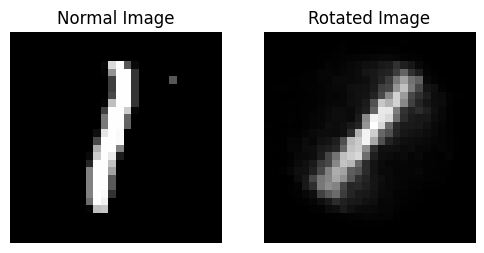

In [397]:
# obtain one batch of training images
# batch = next(iter(train_loader))
# images, labels = batch

# get one image from the batch
img_sample = np.squeeze(X_original.cpu().detach().numpy())
img_sample_rotated = np.squeeze(gX_f.cpu().detach().numpy())

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 5))  # 1 row, 2 columns

# Display the first image in the first subplot
axes[0].imshow(img_sample, cmap='gray')
axes[0].set_title('Normal Image')
axes[0].axis('off')  # Hide the axis

# Display the rotated image in the second subplot
axes[1].imshow(img_sample_rotated, cmap='gray')
axes[1].set_title('Rotated Image')
axes[1].axis('off')  # Hide the axis

In [401]:
Lie = generator.Li.cpu().detach().numpy()#.shape

## Let's retrieve the metric tensor from L

In [438]:
import numpy as np
from scipy.optimize import minimize
from functools import partial

# small push from zero
a = 0.00001 #0.076505

# Define the objective function
# L = L.cpu().numpy()
n_dim = 2
n_channels = 3

def objective(J):

    J = J.reshape((n_dim, n_dim))  # Reshape J back into a matrix
    loss = 0
    for i in range(n_channels):
        loss += np.linalg.norm(Lie[i].T @ J + J @ Lie[i], 'fro')**2
        
    loss -= a * np.linalg.norm(J, 'fro')**2
    return loss


# Initial guess for J
J0 = torch.randn(n_dim*2).numpy()
# Call the optimizer
res = minimize(objective, J0, method='L-BFGS-B')

# Print the optimized J
print(res.x.reshape((2, 2)))

[[-7.20845060e-08  1.02130998e-07]
 [-1.67850140e-07  3.83010847e-09]]


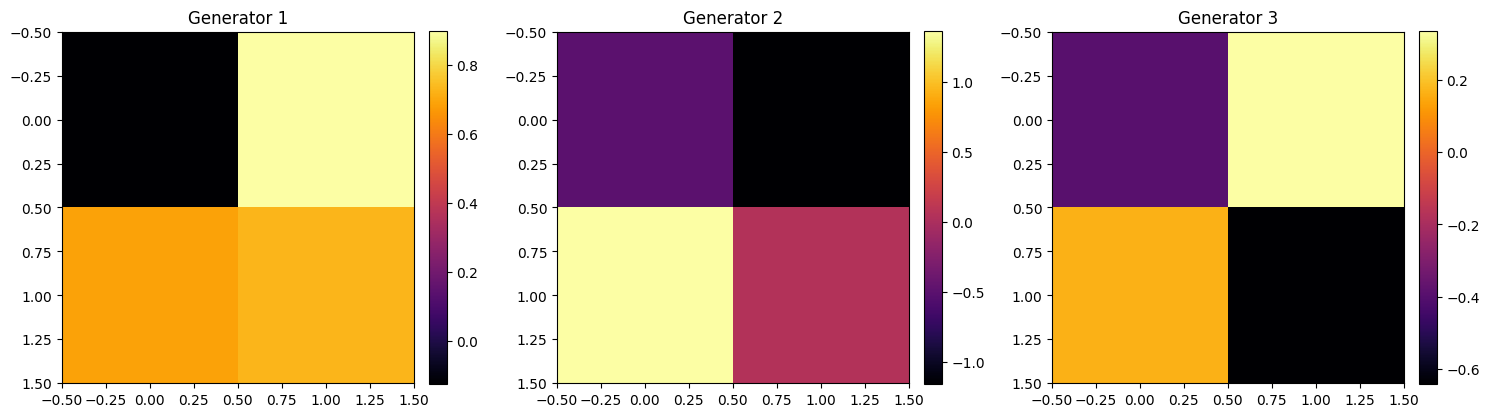

In [436]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first matrix
im1 = axes[0].imshow(Lie[0], cmap='inferno', interpolation='nearest')
axes[0].set_title('Generator 1')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot the second matrix
im2 = axes[1].imshow(Lie[1], cmap='inferno', interpolation='nearest')
axes[1].set_title('Generator 2')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Plot the third matrix
im3 = axes[2].imshow(Lie[2], cmap='inferno', interpolation='nearest')
axes[2].set_title('Generator 3')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

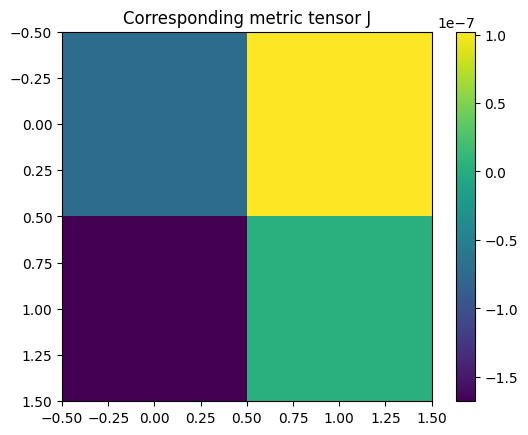

In [439]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(res.x.reshape(2,2))
plt.title("Corresponding metric tensor J")
plt.colorbar()
plt.show()